### Imports

In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import pickle
import time
from array import array
from scipy.interpolate import interp1d
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os
import itertools
sys.path.append('../lib')
if os.environ['CMSSW_VERSION'] != 'CMSSW_10_2_3':
    raise
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
m_D0 = 1.86483
m_Dst = 2.01026
m_Dstst = 2.430

In [3]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [4]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

In [5]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

# Load data

In [6]:
locRD = '../data/cmsRD/skimmed/TnP_Bp2DststMuNu_200522_All.root'
dsRD = rtnp.root2array(locRD)

# datasets_loc = glob('../data/cmsRD/ParkingBPH*/*TagAndProbe_Bp2MuNuDstst_Pip_200522_CAND.root')
# lumi_tot = getLumiByTrigger(datasets_loc, 'Mu12_IP6', verbose=True)
CMS_lumi.integrated_lumi = 5.39#lumi_tot

In [7]:
locMC = '../data/cmsMC_private/BP_Tag_Bp_MuNuDstst_Hardbbbar_evtgen_ISGW2_PUc0_10-2-3/ntuples_TagAndProbe_Bp_MuNuDstst/skimmed/All.root'
dsMC = rtnp.root2array(locMC)

Explore kinematic distribution to choose a binning

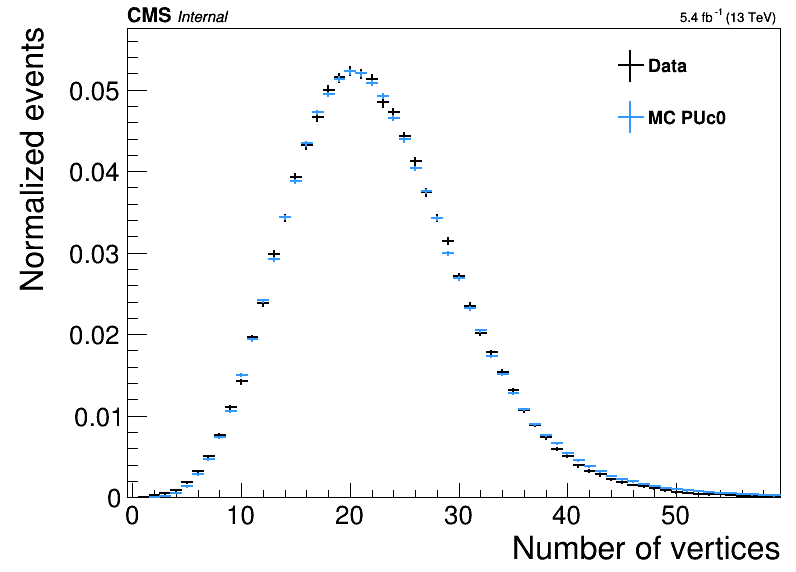

In [8]:
h_list = []
h = create_TH1D(dsRD['N_vtx'], name='h',
                title='Data',
                axis_title=['Number of vertices', 'Normalized events'],
                binning=[60, -0.5, 59.5]
               )
h_list.append(h)

h = create_TH1D(dsMC['N_vtx'], name='h2', title='MC PUc0', binning=h_list[0].binning)
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()

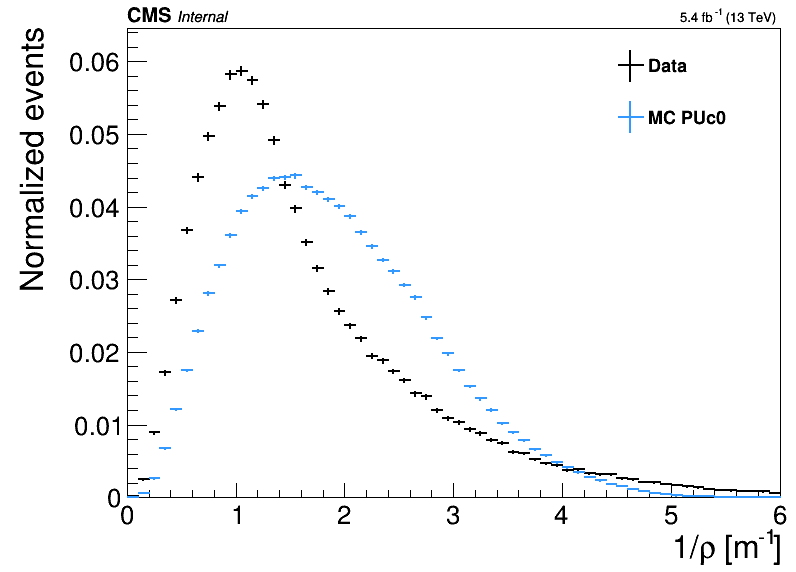

In [9]:
h_list = []
h = create_TH1D(0.3*3.8/dsRD['expPis_pt'], name='h',
                title='Data',
                axis_title=['1/#rho [m^{-1}]', 'Normalized events'],
                binning=[60, 0, 6]
               )
h_list.append(h)

h = create_TH1D(0.3*3.8/dsMC['expPis_pt'], name='h2', title='MC PUc0', binning=h_list[0].binning)
h_list.append(h)

leg = rt.TLegend(0.77, 0.75, 0.95, 0.93)
leg.SetBorderSize(0)
for i, h in enumerate(h_list):
    h.SetLineColor(colors[i])
    h.SetMarkerColor(colors[i])
    h.Sumw2()
    h.Scale(1./h.Integral())
    leg.AddEntry(h, h.GetTitle(), 'lep')
m = SetMaxToMaxHist(h_list)
h_list[0].SetTitle('')

c = drawOnCMSCanvas(CMS_lumi, h_list, 'same')
leg.Draw()
c.Draw()

# Efficiency functions

In [10]:
def fitPoly(h, maskLim, deg, rooFitNorm=False, useChebychev=False, verbose=False):
    x = []
    y = []
    yerr = []
    for i in range(1, h.GetNbinsX()+1):
        xx = h.GetBinCenter(i)
        if xx < maskLim[0] or xx > maskLim[1]:
            x.append(xx)
            y.append(h.GetBinContent(i))
            yerr.append(h.GetBinError(i) if h.GetBinError(i) != 0 else 1)
    if useChebychev:
        p = np.polynomial.chebyshev.chebfit(x, y, deg, w=1./np.array(yerr))
        if verbose:
            plt.errorbar(x,y, yerr=yerr, fmt='.b')
            plt.plot(x, np.polynomial.chebyshev.chebval(x, p), '--r')
    else:
        p = np.polyfit(x,y, deg, w=1./np.array(yerr))
        if verbose:
            plt.errorbar(x,y, yerr=yerr, fmt='.b')
            plt.plot(x, np.polyval(p, x), '--r')
        p = np.flip(p, axis=0)
    if rooFitNorm:
        p /= p[0]
    if verbose:
        print 'Coeff:', list(p)
    return p

In [11]:
def fitResonance(x, varName, xlims, nbins,
                 p0={'mean': 0, 'sigmaN':[], 'sigmaW':[], 'bkg':[]},
                 sigType='doubleGauss',
                 bkgType='pol0',
                 units='MeV', rightText=None, verbose=False):
    h = create_TH1D(x, name='h', title='',
                    axis_title=[varName+' [GeV]', 'Events'],
                    binning=[nbins, xlims[0], xlims[1]]
                   )
    if h.GetMinimum() == 0:
        if verbose: print 'Trying reduce the number of bins'
        nbins = int(nbins*0.5)
        h = create_TH1D(x, name='h', title='',
                        axis_title=[varName+' [GeV]', 'Events'],
                        binning=[nbins, xlims[0], xlims[1]]
                       )
    h.Sumw2()
    N_tot = h.Integral()

    mass = rt.RooRealVar('mass', varName, xlims[0], xlims[1], units)
    
    if sigType == 'doubleGauss':
        mean = rt.RooRealVar('mean', '#mu', p0['mean'], xlims[0], xlims[1])
        sigmaN = rt.RooRealVar('sigmaN', '#sigma_{N}', p0['sigmaN'][0], p0['sigmaN'][1], p0['sigmaN'][2]) 
        sigmaW = rt.RooRealVar('sigmaW', '#sigma_{W}', p0['sigmaW'][0], p0['sigmaW'][1], p0['sigmaW'][2]) 
        gausN = rt.RooGaussian('gausN','gausN', mass, mean, sigmaN)
        gausW = rt.RooGaussian('gausW','gausW', mass, mean, sigmaW)
        fN = rt.RooRealVar('fN', 'f_{N}', 0.5, 0.0, 1.0)
        pdf_sig = rt.RooAddPdf('dGaus', 'sig pdf', rt.RooArgList(gausN, gausW), rt.RooArgList(fN))
    elif sigType.startswith('novo'):
        mean = rt.RooRealVar('mean', '#mu', p0['mean'], xlims[0], xlims[1])
        width = rt.RooRealVar('width', 'w', p0['width'][0], p0['width'][1], p0['width'][2])
        tail = rt.RooRealVar('tail', '#tau', p0['tail'][0], p0['tail'][1], p0['tail'][2])
        if sigType.endswith('gaus'):
            sigma = rt.RooRealVar('sigma', '#sigma', p0['sigma'][0], p0['sigma'][1], p0['sigma'][2])
            gaus = rt.RooGaussian('gaus','gaus', mass, mean, sigma)
            novo_pdf = rt.RooNovosibirsk('novo', 'novo', mass, mean, width, tail)
            fG = rt.RooRealVar('fN', 'f_{N}', p0['fG'], 0.0, 1.0)
            pdf_sig = rt.RooAddPdf('novoGaus', 'sig pdf', rt.RooArgList(gaus, novo_pdf), rt.RooArgList(fG))
        else:
            pdf_sig = rt.RooNovosibirsk('novo', 'sig pdf', mass, mean, width, tail)
    elif sigType.startswith('CB'):
        mean = rt.RooRealVar('mean', '#mu', p0['mean'], xlims[0], xlims[1])
        width = rt.RooRealVar('width', 'w', p0['width'][0], p0['width'][1], p0['width'][2])
        alpha = rt.RooRealVar('alpha', '#alpha', p0['alpha'][0], p0['alpha'][1], p0['alpha'][2])
        n = rt.RooRealVar('n', 'n', p0['n'][0], p0['n'][1], p0['n'][2])
        if sigType.endswith('gaus'):
            sigma = rt.RooRealVar('sigma', '#sigma', p0['sigma'][0], p0['sigma'][1], p0['sigma'][2])
            gaus = rt.RooGaussian('gaus','gaus', mass, mean, sigma)
            cb_pdf = rt.RooCBShape('CB', 'sig pdf', mass, mean, width, alpha, n)
            fG = rt.RooRealVar('fG', 'f_{G}', p0['fG'], 0.0, 1.0)
            pdf_sig = rt.RooAddPdf('CBGaus', 'sig pdf', rt.RooArgList(gaus, cb_pdf), rt.RooArgList(fG))
        else:
            pdf_sig = rt.RooCBShape('CB', 'sig pdf', mass, mean, width, alpha, n)
    elif sigType == 'doubleCB':
        mean = rt.RooRealVar('mean', '#mu', p0['mean'], xlims[0], xlims[1])
        widthN = rt.RooRealVar('widthN', 'w', p0['widthN'][0], p0['widthN'][1], p0['widthN'][2])
        widthW = rt.RooRealVar('widthW', 'w', p0['widthW'][0], p0['widthW'][1], p0['widthW'][2])
        alpha = rt.RooRealVar('alpha', '#alpha', p0['alpha'][0], p0['alpha'][1], p0['alpha'][2])
        n = rt.RooRealVar('n', 'n', p0['n'][0], p0['n'][1], p0['n'][2])
        fN = rt.RooRealVar('fN', 'f_{N}', p0['fN'], 0.0, 1.0)
        cb_N = rt.RooCBShape('cbN', 'cbN', mass, mean, widthN, alpha, n)
        cb_W = rt.RooCBShape('cbW', 'cbW', mass, mean, widthW, alpha, n)
        pdf_sig = rt.RooAddPdf('doubleCB', 'sig pdf', rt.RooArgList(cb_N, cb_W), rt.RooArgList(fN))
        
    else:
        raise
    nsig = rt.RooRealVar('nsig', 'N_{S}', 0.9*N_tot, 0, 10*N_tot)
    pdf_sig_ext = rt.RooExtendPdf('esig', 'esig', pdf_sig, nsig)
    
    if bkgType=='exp':
        lam = rt.RooRealVar('lam', '#lambda', p0['bkg'][0], p0['bkg'][1], p0['bkg'][2], units+'^{-1}')
        pdf_bkg = rt.RooExponential('expo', 'bkg pdf', mass, lam)
    elif bkgType.startswith('pol'):
        deg = int(bkgType[3:])
        if verbose: print 'Fitting with polinomial (degree = {})'.format(deg)
        if p0['bkg'] == 'auto':
            p0['bkg'] = fitPoly(h, p0['maskLim'], deg, rooFitNorm=True, verbose=verbose)
        bkgRooVar = []
        for iv in range(1, deg+1):
            bkgRooVar.append(rt.RooRealVar('a'+str(iv), 'a'+str(iv), p0['bkg'][iv]))
        pdf_bkg = rt.RooPolynomial('poly', 'bkg pdf', mass, rt.RooArgList(*bkgRooVar), 1)
    elif bkgType.startswith('cheb'):
        deg = int(bkgType[4:])
        if verbose: print 'Fitting with Chebycev polinomial (degree = {})'.format(deg)
        if p0['bkg'] == 'auto':
            p0['bkg'] = fitPoly(h, p0['maskLim'], deg, rooFitNorm=True, useChebychev=True, verbose=verbose)
        bkgRooVar = []
        for iv in range(1, deg+1):
            bkgRooVar.append(rt.RooRealVar('a'+str(iv), 'a'+str(iv), p0['bkg'][iv]))
        pdf_bkg = rt.RooChebychev('polyCheb', 'bkg pdf', mass, rt.RooArgList(*bkgRooVar))
    elif bkgType == 'dmBkg':
        dm0 = rt.RooRealVar('dm0', 'dm0', p0['dm'][0], p0['dm'][1], p0['dm'][2], units)
        a = rt.RooRealVar('a', 'a', p0['a'][0], p0['a'][1], p0['a'][2], units)
        b = rt.RooRealVar('b', 'b', p0['b'][0], p0['b'][1], p0['b'][2], units)
        c = rt.RooRealVar('c', 'c', p0['c'][0], p0['c'][1], p0['c'][2], units)
        pdf_bkg = rt.RooDstD0BG('dmBkg', 'dmBkg', mass, dm0, c, a, b)
    else:
        raise
    nbkg = rt.RooRealVar('nbkg', 'N_{B}', 0.1*N_tot, 0, 10*N_tot)
    pdf_bkg_ext = rt.RooExtendPdf('ebkg', 'ebkg', pdf_bkg, nbkg)

    pdf_tot = rt.RooAddPdf('pdftot', 'pdftot', rt.RooArgList(pdf_sig_ext, pdf_bkg_ext))
    
    unbinnedUsed = False
    if h.GetMinimum() == 0 or h.Integral() < 2*h.binning[0]:
        if verbose: print 'Using unbinned likelihood ({:.0f} events)'.format(h.Integral())
        auxdf = pd.DataFrame(x, columns=['mass'])
        T = rtnp.array2tree(auxdf.to_records())
        data = rt.RooDataSet('d', 'data', T, rt.RooArgSet(mass))
        unbinnedUsed = True
    else:
        data = rt.RooDataHist('d', 'data', rt.RooArgList(mass), h)
        if verbose: print 'Using binned likeihood'

#     fr = pdf_tot.fitTo(data, rf.PrintLevel(0 if verbose else -1), rf.Save())
    fr = pdf_tot.fitTo(data, rf.PrintLevel(-1), rf.Save())
    
    frame = mass.frame(rf.Title(""), rf.Bins(h.binning[0]))
    dataPlot = data.plotOn(frame, rf.MarkerStyle(1), rf.DrawOption('E1'), 
                           rf.MarkerColor(1), rf.LineColor(1), rf.MarkerStyle(15))
    
    pdf_tot.plotOn(frame, rf.LineColor(rt.kBlack), rf.LineWidth(1))

    dof = fr.floatParsFinal().getSize()
    chi2 = frame.chiSquare(dof)*dof
    pval = rt.ROOT.Math.chisquared_cdf_c(chi2, dof)
    if verbose: print 'chi2: {:.1f}/{:.0f} {:.3f}'.format(chi2, dof, pval)

    pdf_tot.plotOn(frame, rf.Components('ebkg'), rf.LineColor(rt.kRed), rf.LineWidth(2), rf.LineStyle(7))
    pdf_tot.plotOn(frame, rf.Components('esig'), rf.LineColor(rt.kBlue), rf.LineWidth(2), rf.LineStyle(7))

    x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.7
    x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.95
    pTxt = rt.TPaveText(x_min, 0.3*dataPlot.GetMaximum(), x_max, 0.85*dataPlot.GetMaximum())
    pTxt.SetBorderSize(0)
    pTxt.SetFillStyle(0)
    pTxt.SetTextAlign(11)
    pTxt.AddText('#chi^{{2}}: {:.1f}/{:.0f} ({:.2f})'.format(chi2, dof, pval))
    pTxt.AddText('N_{{sig}} = {:.0f} +/- {:.0f}'.format(nsig.getVal(), nsig.getError()))
    if sigType == 'doubleGauss':
        pTxt.AddText('#mu = {:.1f} +/- {:.1f} '.format(mean.getVal(), mean.getError()) + units)
        pTxt.AddText('#sigma_{{N}} = {:.1f} +/- {:.1f} '.format(sigmaN.getVal(), sigmaN.getError()) + units)
        pTxt.AddText('#sigma_{{W}} = {:.1f} +/- {:.1f} '.format(sigmaW.getVal(), sigmaW.getError()) + units)
        pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))
    elif sigType.startswith('novo'):
        pTxt.AddText('#mu = {:.1f} +/- {:.1f} '.format(mean.getVal(), mean.getError()) + units)
        pTxt.AddText('w = {:.1f} +/- {:.1f} '.format(width.getVal(), width.getError()) + units)
        pTxt.AddText('#tau = {:.2f} +/- {:.2f}'.format(tail.getVal(), tail.getError()))
        if sigType.endswith('gaus'):
            pTxt.AddText('#sigma = {:.1f} +/- {:.1f} '.format(sigma.getVal(), sigma.getError()) + units)
            pTxt.AddText('f_{{G}} = {:.2f} +/- {:.2f}'.format(fG.getVal(), fG.getError()))
    elif sigType.startswith('CB'):
        pTxt.AddText('#mu = {:.1f} +/- {:.1f} '.format(mean.getVal(), mean.getError()) + units)
        pTxt.AddText('w = {:.1f} +/- {:.1f} '.format(width.getVal(), width.getError()) + units)
        pTxt.AddText('#alpha = {:.2f} +/- {:.2f}'.format(alpha.getVal(), alpha.getError()))
        pTxt.AddText('n = {:.2f} +/- {:.2f}'.format(n.getVal(), n.getError()))
        if sigType.endswith('gaus'):
            pTxt.AddText('#sigma = {:.1f} +/- {:.1f} '.format(sigma.getVal(), sigma.getError()) + units)
            pTxt.AddText('f_{{G}} = {:.2f} +/- {:.2f}'.format(fG.getVal(), fG.getError()))
    elif sigType == 'doubleCB':
        pTxt.AddText('#mu = {:.1f} +/- {:.1f} '.format(mean.getVal(), mean.getError()) + units)
        pTxt.AddText('w_{{N}} = {:.1f} +/- {:.1f} '.format(widthN.getVal(), widthN.getError()) + units)
        pTxt.AddText('w_{{W}} = {:.1f} +/- {:.1f} '.format(widthW.getVal(), widthW.getError()) + units)
        pTxt.AddText('#alpha = {:.2f} +/- {:.2f}'.format(alpha.getVal(), alpha.getError()))
        pTxt.AddText('n = {:.2f} +/- {:.2f}'.format(n.getVal(), n.getError()))
        pTxt.AddText('f_{{N}} = {:.2f} +/- {:.2f}'.format(fN.getVal(), fN.getError()))
    frame.addObject(pTxt)
    
    if not rightText is None:
        x_min = mass.getMin() + (mass.getMax()-mass.getMin())*0.05
        x_max = mass.getMin() + (mass.getMax()-mass.getMin())*0.25
        pTxtR = rt.TPaveText(x_min, 0.7*dataPlot.GetMaximum(), x_max, 0.92*dataPlot.GetMaximum())
        pTxtR.SetBorderSize(0)
        pTxtR.SetFillStyle(0)
        for s in rightText:
            pTxtR.AddText(s)
        frame.addObject(pTxtR)
    
    frame.GetXaxis().SetNdivisions(508)
    return frame, [float(nsig.getVal()), float(nsig.getError())], [chi2, dof, pval], h

In [12]:
def analyzeBin(idx, verbose=False):
#     sigType='novo+gaus'
#     sigType='doubleGauss'
    sigType='doubleCB'
    bkgType='pol1'
    
    p0={
#         'mean': 0, 'width':[35., 20., 100.], 'tail':[-0.2, -0.4, -0.15], 'sigma':[20., 15., 30.], 'fG': 0.2,
#         'mean': 0, 'sigmaN':[20., 1., 100.], 'sigmaW':[350., 10., 500.], 
        'mean': 0, 'widthN':[20., 10., 40.], 'widthW':[200., 50., 500.], 'alpha':[-0.2, -1, 0], 'n':[2, 0.1, 100], 'fN': 0.1,
        'bkg':'auto', 'maskLim':[-80,80]
       }

    print idx, 'started'
    psCut = []
    lim = {}
    psStrings = []
    sel = np.ones_like(ds['dm_expDstpip_pik']).astype(np.bool)
    for n, i in idx.iteritems():
        lim[n] = [binning[n][i], binning[n][i+1]]
        auxSel = np.logical_and(ds[n] > lim[n][0], ds[n] < lim[n][1])
        sel = np.logical_and(sel, auxSel)
        psS = '{:.1f} < '.format(lim[n][0]) + varDic[n] + ' < {:.1f}'.format(lim[n][1])
        psStrings.append(psS)
    rt.TGaxis.SetMaxDigits(3)

    if verbose: 
        print ' --- Total ---'
        print 'N candidates: ', sel.shape[0]
    st = time.time()
    x = 1e3*(ds['dm_expDstpip_pik'][sel] - (m_Dstst - m_D0))
    
    frTot, nSigTot, pValTot, _ = fitResonance(x, '#Deltam(D^{#diamond}#pi^{+}, #pi^{-}K^{+}) - #Deltam_{pdg}', 
                                              [-250, 400], 50,
                                              sigType=sigType, bkgType=bkgType, p0=p0,
                                              rightText=psStrings, verbose=verbose)
    if verbose: 
        print 'Time: {:.1f} s'.format(time.time()-st)
        print ' --- Passed ---'
    st = time.time()
    print 'Timer started'
    selPass = np.logical_and(sel, np.abs(1e3*(ds['dm_D0pis_piK']-(m_Dst-m_D0))) < 2.)
    print 'selPass computed'
    if verbose: 'N candidates: ', selPass.shape[0]
    x = 1e3*(ds['dm_expDstpip_pik'][selPass] - (m_Dstst - m_D0))
    frPass, nSigPass, pValPass, _ = fitResonance(x, '#Deltam(D^{#diamond}#pi^{+}, #pi^{-}K^{+}) - #Deltam_{pdg}', 
                                                 [-250, 400], 50,
                                                 sigType=sigType, bkgType=bkgType, p0=p0,
                                                 rightText=['|#Deltam_{reco}-#Deltam_{pdg}| < 2 MeV'] + psStrings, 
                                                 verbose=verbose)
    if verbose: print 'Time: {:.1f} s'.format(time.time()-st)
    cTag = '_' + '_'.join([str(idx[k]) for k in np.sort(idx.keys())])
    c = rt.TCanvas('c'+cTag, 'c'+cTag, 50, 50, 1200, 600)
    c.SetTickx(0)
    c.SetTicky(0)
    c.Divide(2)

    p = c.cd(1)
    frTot.Draw()
    p.SetRightMargin(0.04)
    CMS_lumi.CMS_lumi(p, -1, 33)
    p = c.cd(2)
    frPass.Draw()
    p.SetRightMargin(0.04)
    CMS_lumi.CMS_lumi(p, -1, 33)
    
    imgLoc = '../data/calibration/trackingEfficiency/figFit'+dataset
    if not os.path.isdir(imgLoc):
        os.makedirs(imgLoc)
        print 'Creating', imgLoc
    c.SaveAs(imgLoc + '/'+ '_'.join([k+str(idx[k]) for k in np.sort(idx.keys())]) +'.png')
    print idx, 'done'
    return c, idx, nSigTot, pValTot, nSigPass, pValPass

# Run the fit in each bin

In [13]:
dataset = 'RD'
if dataset == 'RD':
    CMS_lumi.extraText = '     Internal'
    CMS_lumi.integrated_lumi = 5.39#lumi_tot
    ds = dsRD
elif dataset == 'MC':
    CMS_lumi.extraText = '     Simulation Internal'    
    CMS_lumi.integrated_lumi = None
    ds = dsMC

In [14]:
varDic = {
    'expPis_k': '1/#rho^{#diamond}_{#pi}',
    'N_vtx': 'N_{vtx}'
}
binning = {'expPis_k': array('d', [0, 0.8, 1.2, 2, 5, 100]),
           'N_vtx': array('d', [0, 12, 17, 20, 23, 28, 35, 70])
          }

In [15]:
h2 = {}
for var, cat in itertools.product(['N', 'Chi2'], ['tot', 'pass']):
    h2[var+cat] = rt.TH2D('h2'+var+cat, '', 
                          len(binning['expPis_k'])-1, binning['expPis_k'],
                          len(binning['N_vtx'])-1, binning['N_vtx'],)

### Test

In [16]:
bTest = {'expPis_k': 2, 'N_vtx':1}

7841 1013
Fitting with polinomial (degree = 1)
Coeff: [1.0, -0.0016086570849752758]
Using binned likeihood
chi2: 10.5/8 0.234


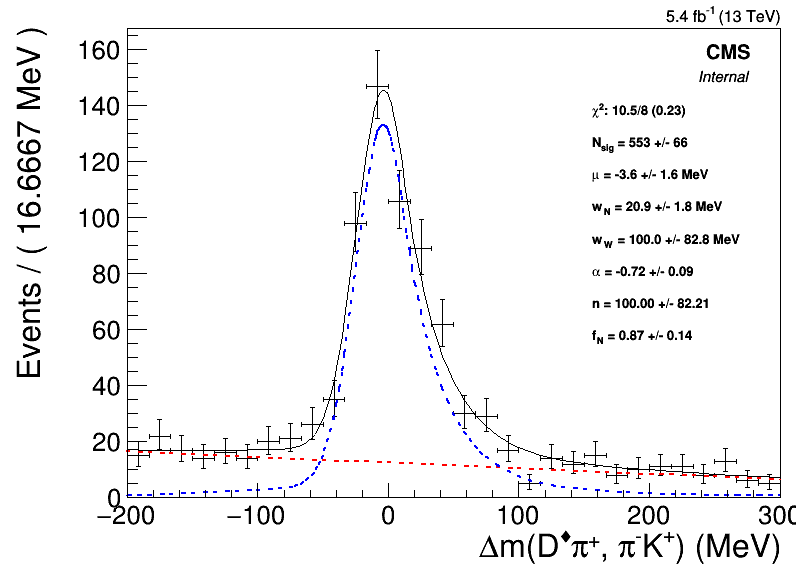

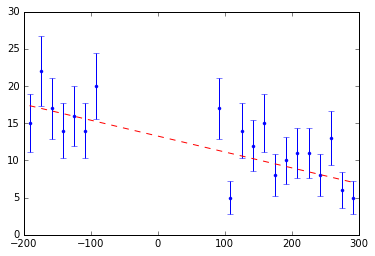

In [17]:
sel = np.ones_like(ds['dm_expDstpip_pik']).astype(np.bool)
for n, i in bTest.iteritems():
    auxSel = np.logical_and(ds[n] > binning[n][i], ds[n] < binning[n][i+1])
    sel = np.logical_and(sel, auxSel)
# sel = np.logical_and(np.abs(ds['N_vtx']-15) < 3, 0.3*3.8/ds['expPis_pt'] < 1.2)
# # sel = 0.3*3.8/ds['expPis_pt'] > 1.2
# sel = np.logical_and(sel, np.abs(1e3*(ds['dm_D0pis_piK']-(m_Dst-m_D0))) < 2.)

selPass = np.logical_and(sel, np.abs(1e3*(ds['dm_D0pis_piK']-(m_Dst-m_D0))) < 2.)
print np.sum(sel), np.sum(selPass)

x = 1e3*(ds['dm_expDstpip_pik'][selPass] - (m_Dstst - m_D0))

out = fitResonance(x, '#Deltam(D^{#diamond}#pi^{+}, #pi^{-}K^{+})', [-200, 300], 30,
#                    sigType='doubleGauss', 
#                    sigType='novo+gaus',
#                    sigType='CB+gaus', 
                   sigType='doubleCB', 
                   bkgType='pol1',
                   p0={
#                        'mean': 0, 'sigmaN':[20., 1., 100.], 'sigmaW':[350., 10., 500.], 
#                        'mean': 0, 'width':[35., 20., 100.], 'tail':[-0.2, -0.4, -0.15], 'sigma':[20., 15., 30.], 'fG': 0.1,
#                        'mean': 0, 'width':[35., 20., 100.], 'alpha':[-0.2, -5, 5], 'n':[2, 0.1, 100], 'sigma':[20., 1., 25.], 'fG': 0.1,
                       'mean': 0, 'widthN':[20., 1., 50.], 'widthW':[200., 100., 500.], 'alpha':[-0.2, -5, 5], 'n':[2, 0.1, 100], 'fN': 0.1,
                       'bkg':'auto', 'maskLim':[-80,80]
                      },
                   units='MeV', rightText=None, verbose=True)
c = rt.TCanvas('c', 'c', 50, 50, 800,600)
c.SetTickx(0)
c.SetTicky(0)

out[0].Draw()
CMS_lumi.CMS_lumi(c, -1, 33)
c.Draw()

{'N_vtx': 1, 'expPis_k': 2} started
 --- Total ---
N candidates:  172081
Fitting with polinomial (degree = 1)
Coeff: [1.0, -0.0018517977093699199]
Using binned likeihood
chi2: 16.7/8 0.034
Time: 0.2 s
 --- Passed ---
Timer started
selPass computed
Fitting with polinomial (degree = 1)
Using binned likeihood
chi2: 9.6/8 0.292
Time: 0.0 s
{'N_vtx': 1, 'expPis_k': 2} done
Total time: 0.0 mins


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


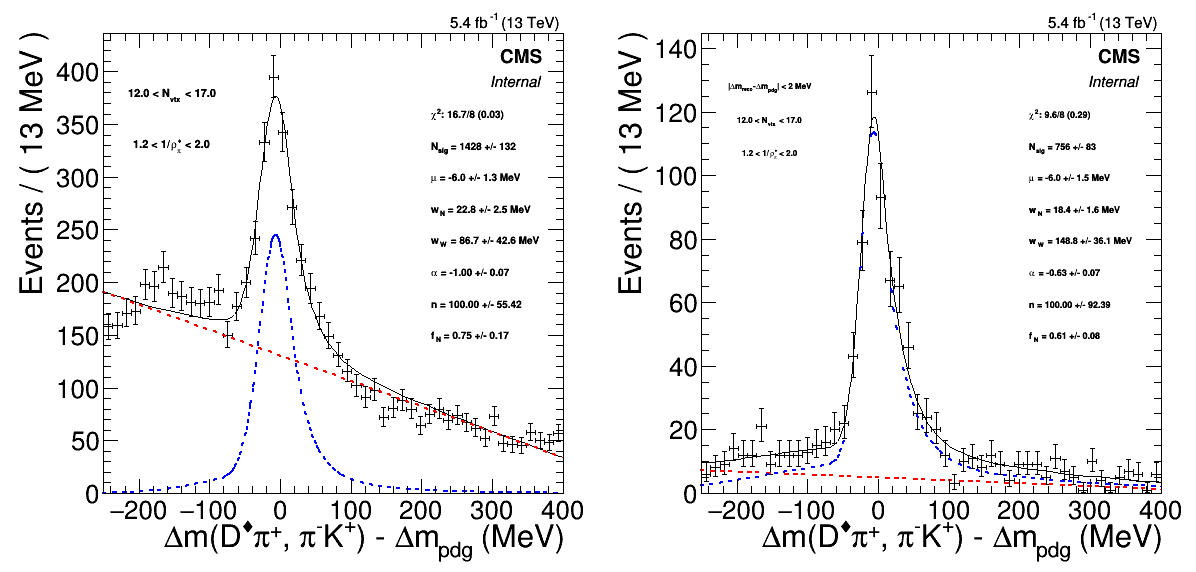

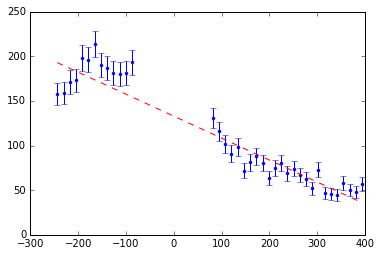

In [18]:
start = time.time()
testOutput = analyzeBin(bTest, verbose=True)
testOutput[0].Draw()
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

### Full run

In [19]:
inputs = []
for i1 in range(len(binning['expPis_k'])-1):
    for i2 in range(len(binning['N_vtx'])-1):
        idx = {'expPis_k': i1, 'N_vtx':i2}
        inputs.append(idx)
print 'Total bins:', len(inputs)

Total bins: 35


In [20]:
multiCpu = False
start = time.time()
if multiCpu:
    N_max = max(1, 15)
    N_request = min(len(inputs), N_max)
    print 'Parallelization factor:', N_request
    p = multiprocessing.Pool(N_request)
    output = p.map(analyzeBin, inputs)
else:
    output = []
    for i, inpt in enumerate(inputs):
        print 'Bin', i
        output.append(analyzeBin(inpt))
print 'Total time: {:.1f} mins'.format((time.time() - start)/60.)

Bin 0
{'N_vtx': 0, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 0, 'expPis_k': 0} done
Bin 1

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



{'N_vtx': 1, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 1, 'expPis_k': 0} done
Bin 2
{'N_vtx': 2, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 2, 'expPis_k': 0} done
Bin 3
{'N_vtx': 3, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 3, 'expPis_k': 0} done
Bin 4
{'N_vtx': 4, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 4, 'expPis_k': 0} done
Bin 5
{'N_vtx': 5, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 5, 'expPis_k': 0} done
Bin 6
{'N_vtx': 6, 'expPis_k': 0} started
Timer started
selPass computed
{'N_vtx': 6, 'expPis_k': 0} done
Bin 7
{'N_vtx': 0, 'expPis_k': 1} started
Timer started
selPass computed
{'N_vtx': 0, 'expPis_k': 1} done
Bin 8
{'N_vtx': 1, 'expPis_k': 1} started
Timer started
selPass computed
{'N_vtx': 1, 'expPis_k': 1} done
Bin 9
{'N_vtx': 2, 'expPis_k': 1} started
Timer started
selPass computed
{'N_vtx': 2, 'expPis_k': 1} done
Bin 10
{'N_vtx': 3, 'expPis_k': 1} started
Timer st

Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent
Error in <ROOT::Math::FitResult>: FitConfiguration and Minimizer result are not consistent


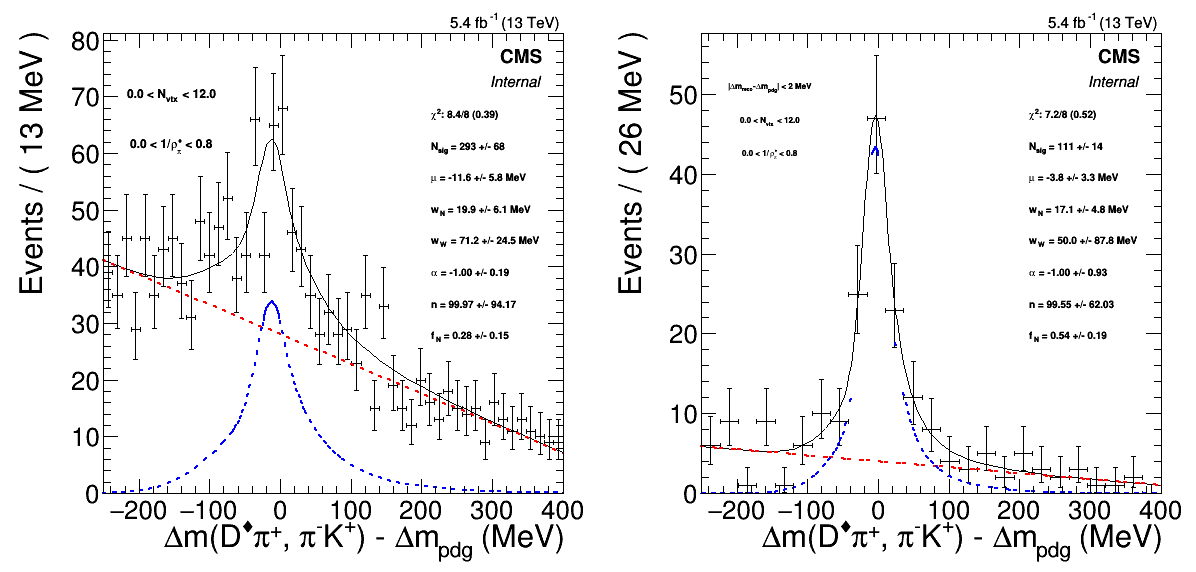

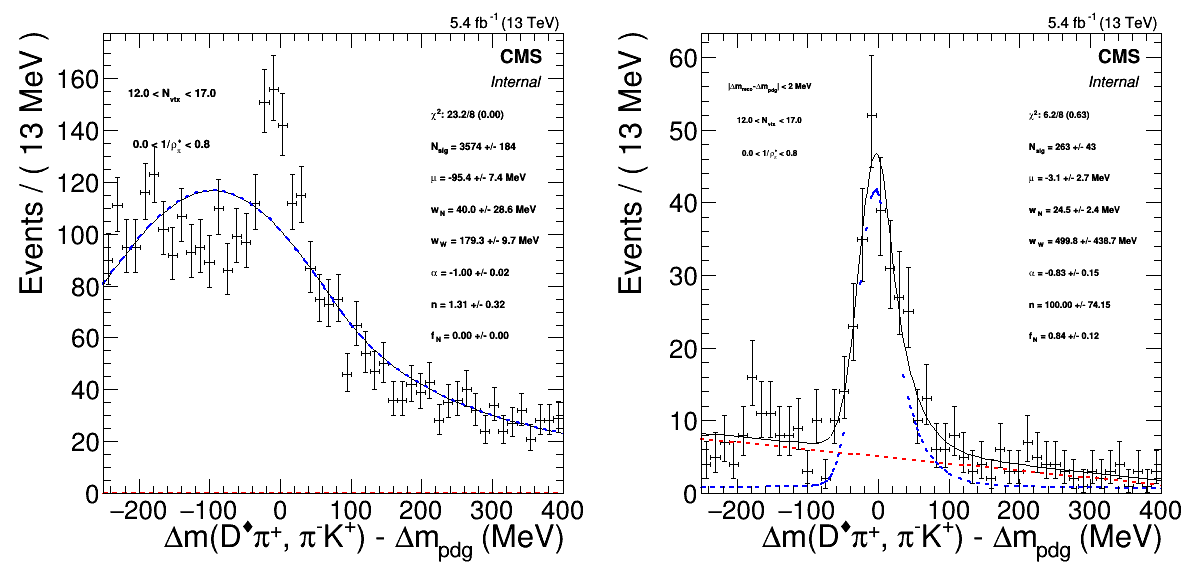

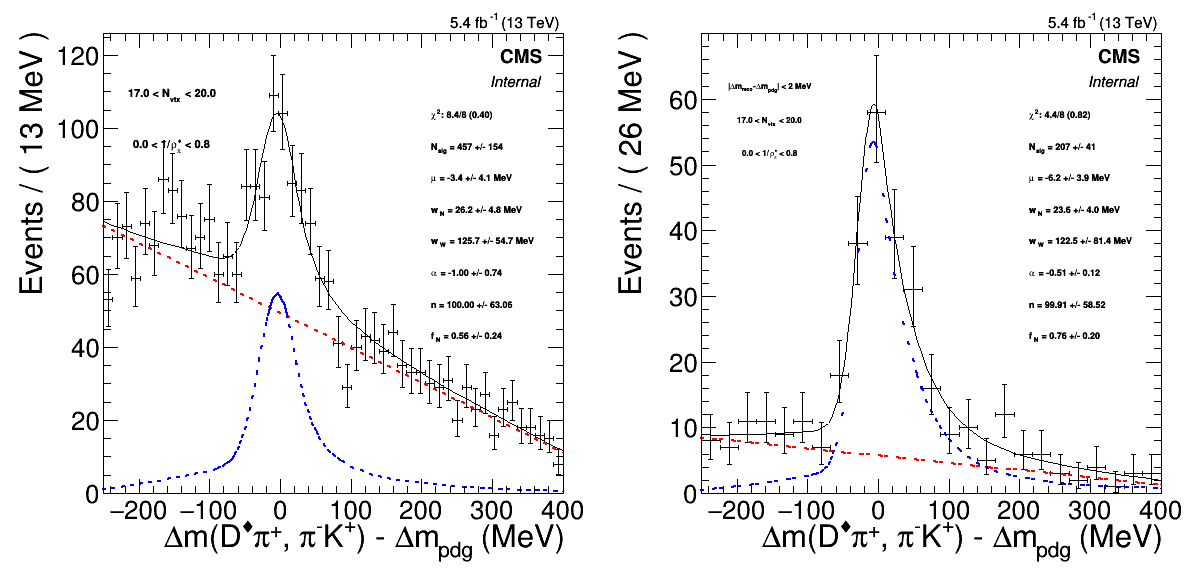

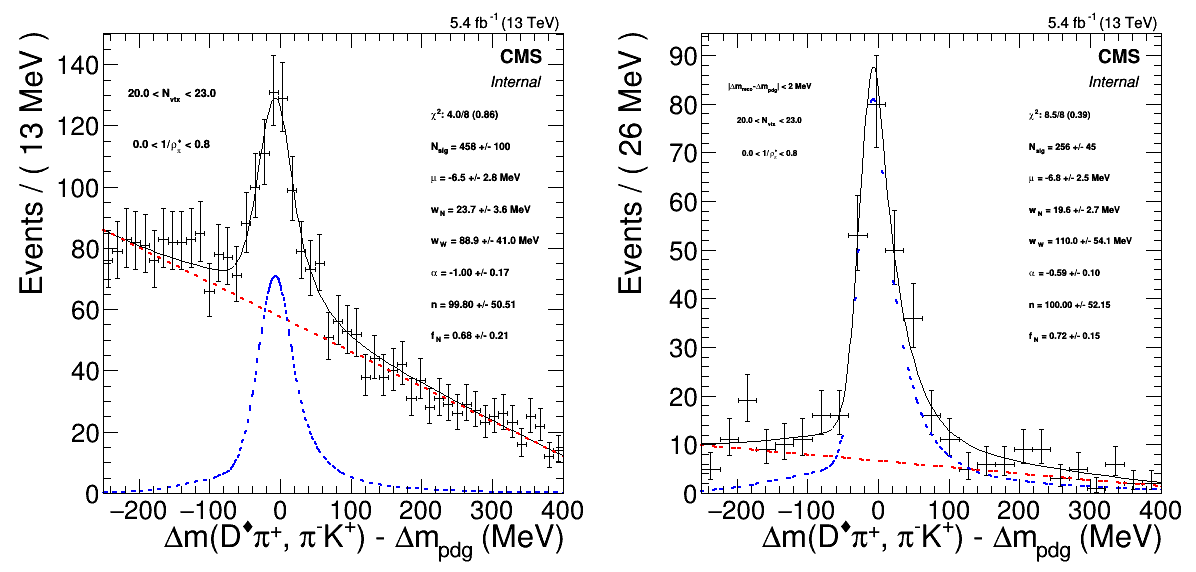

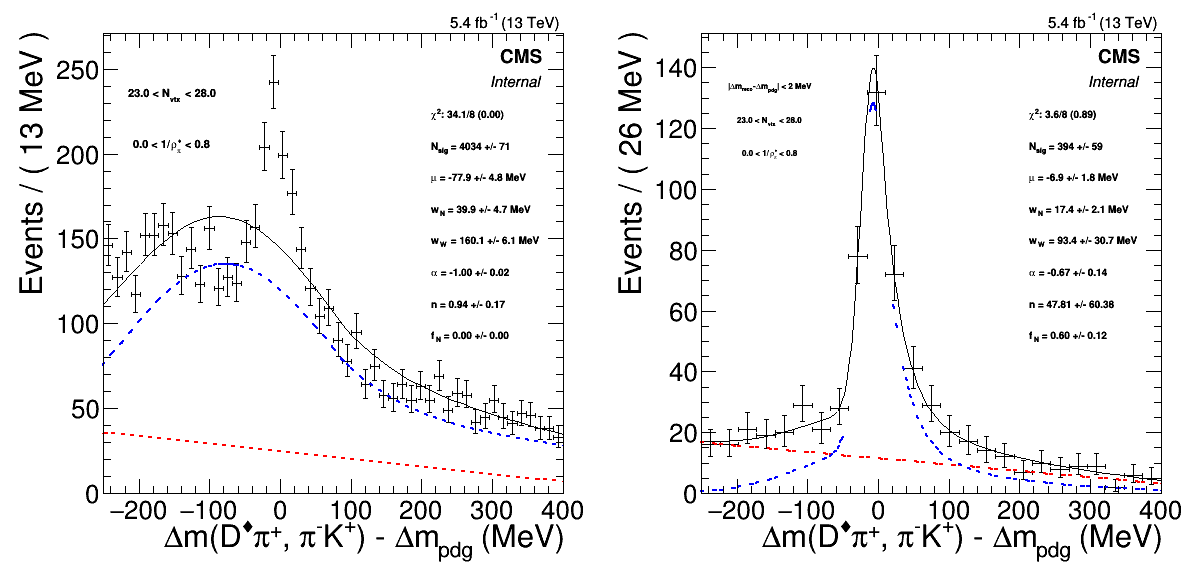

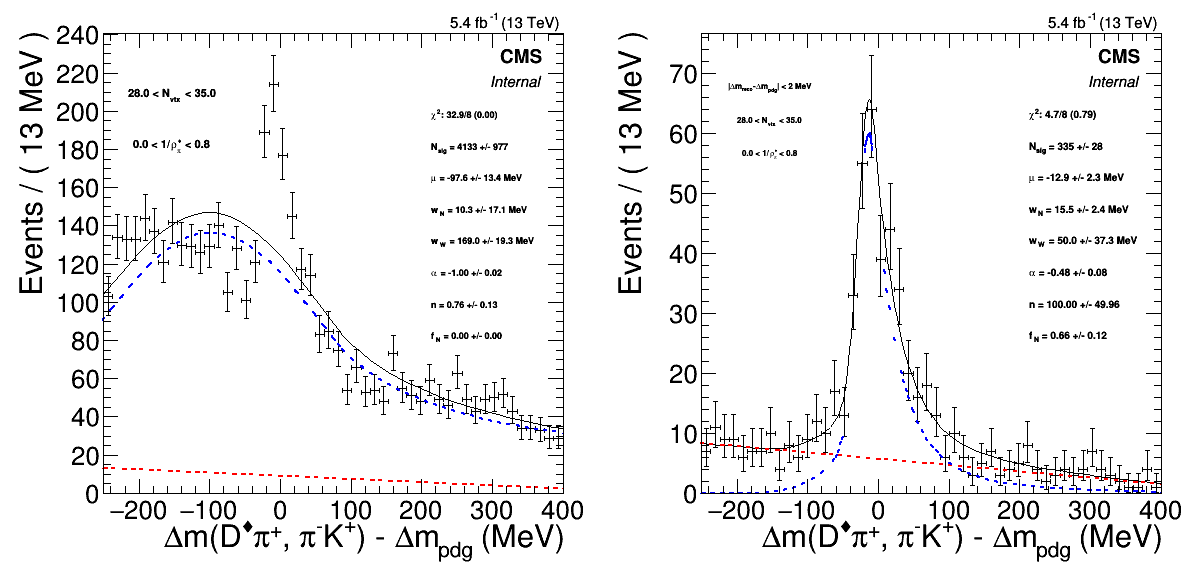

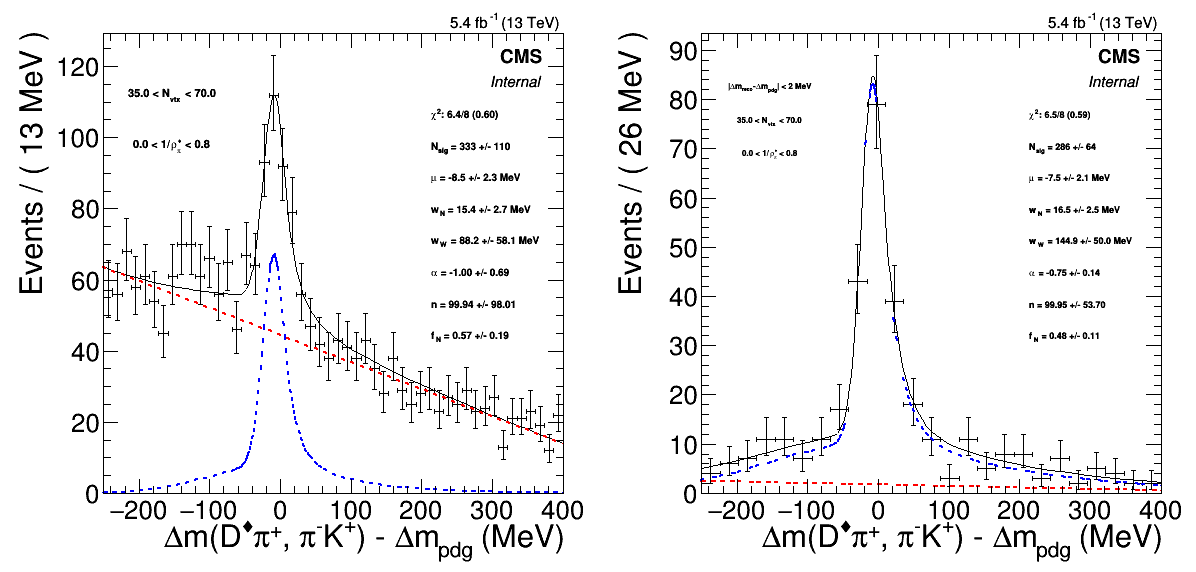

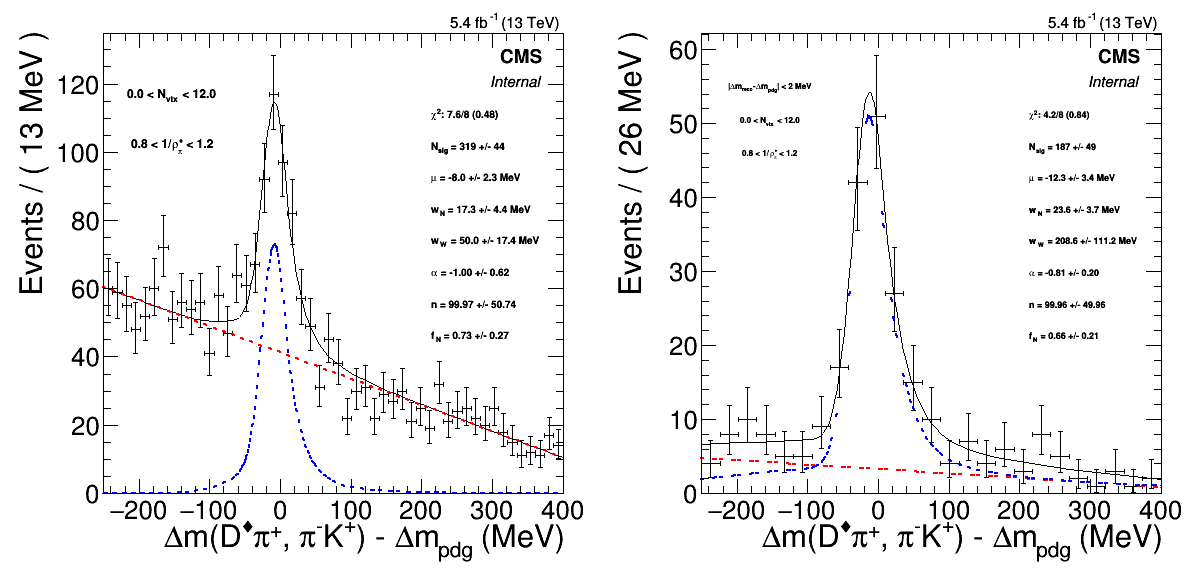

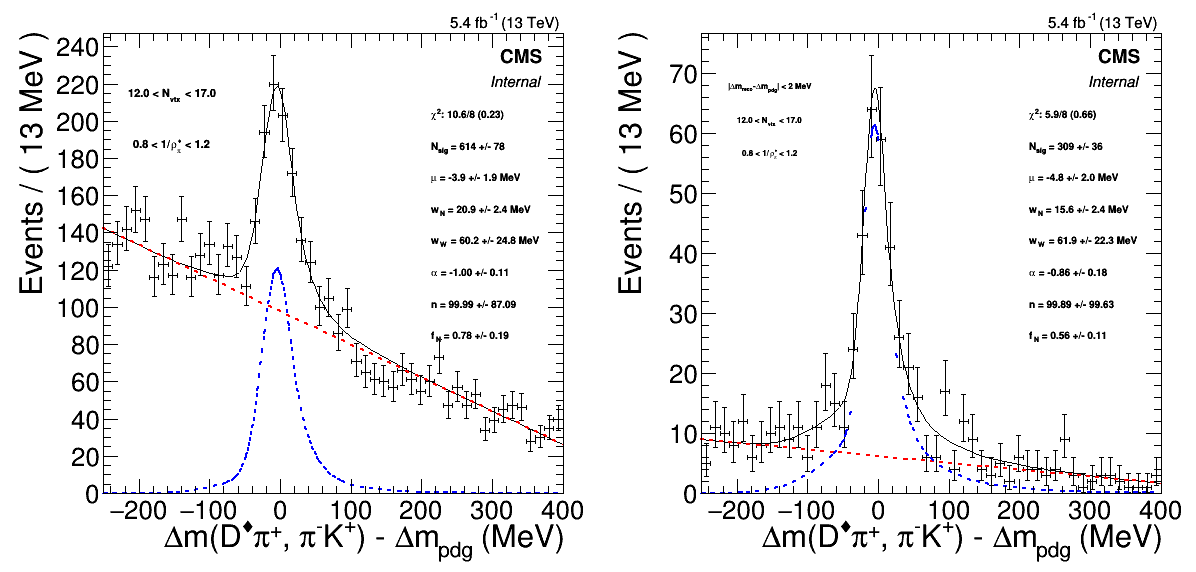

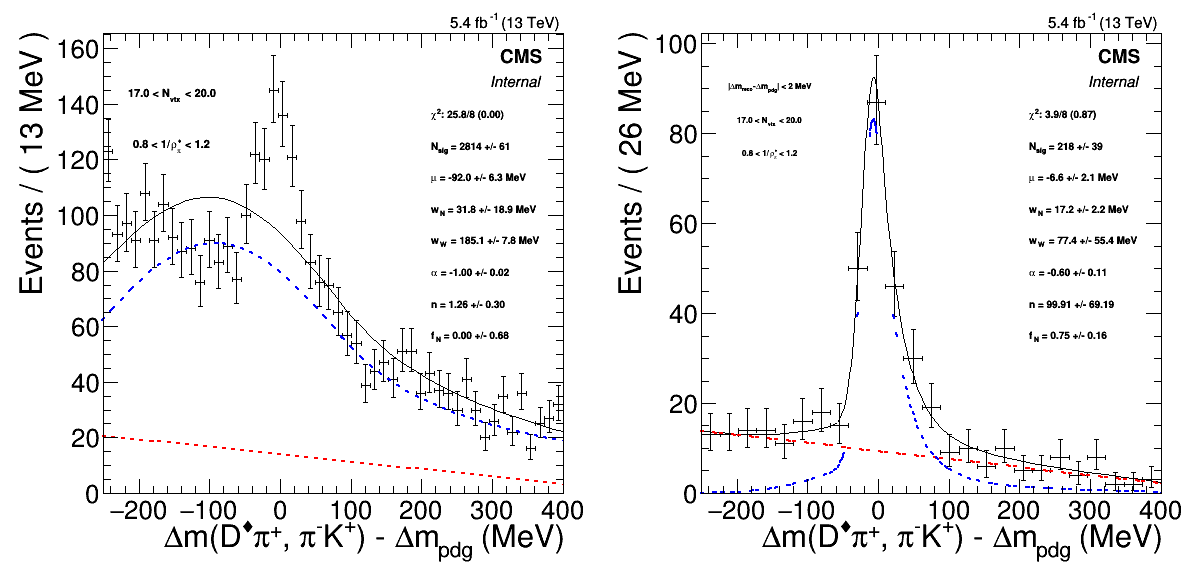

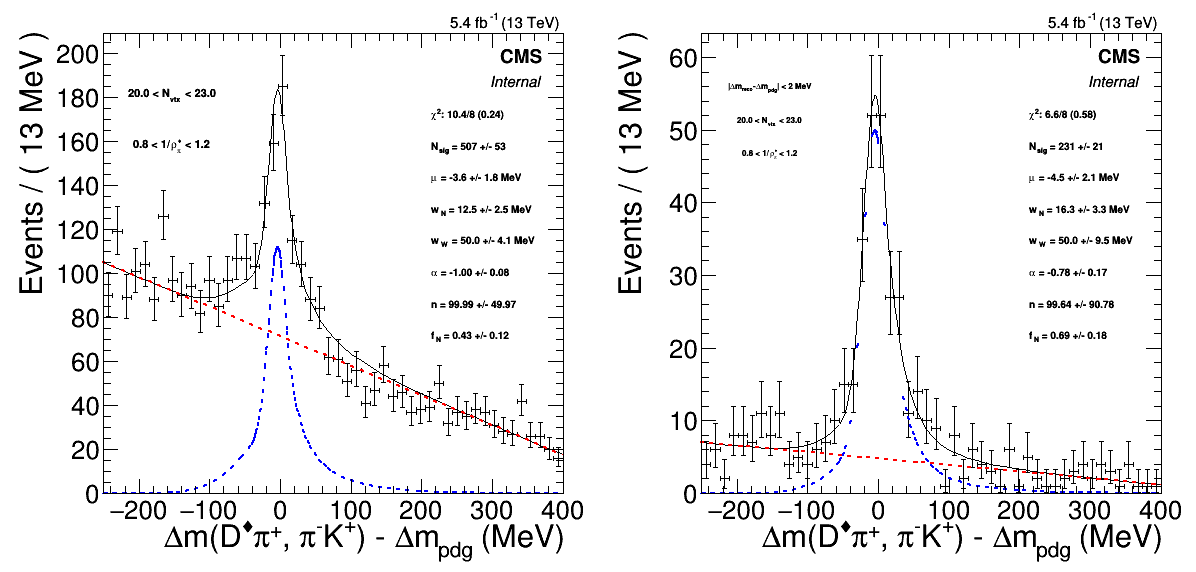

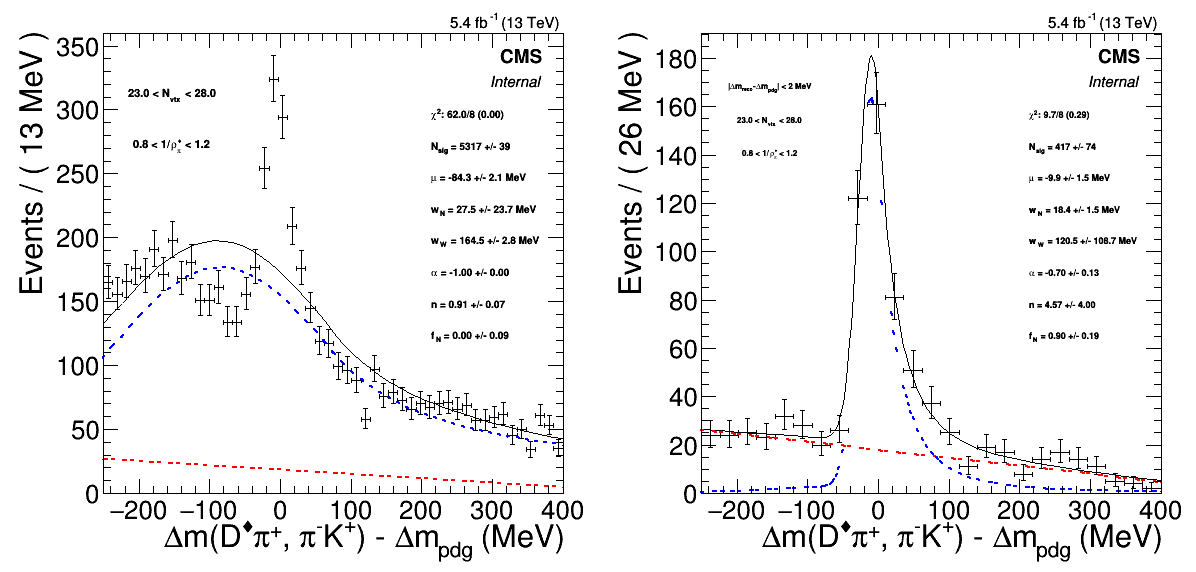

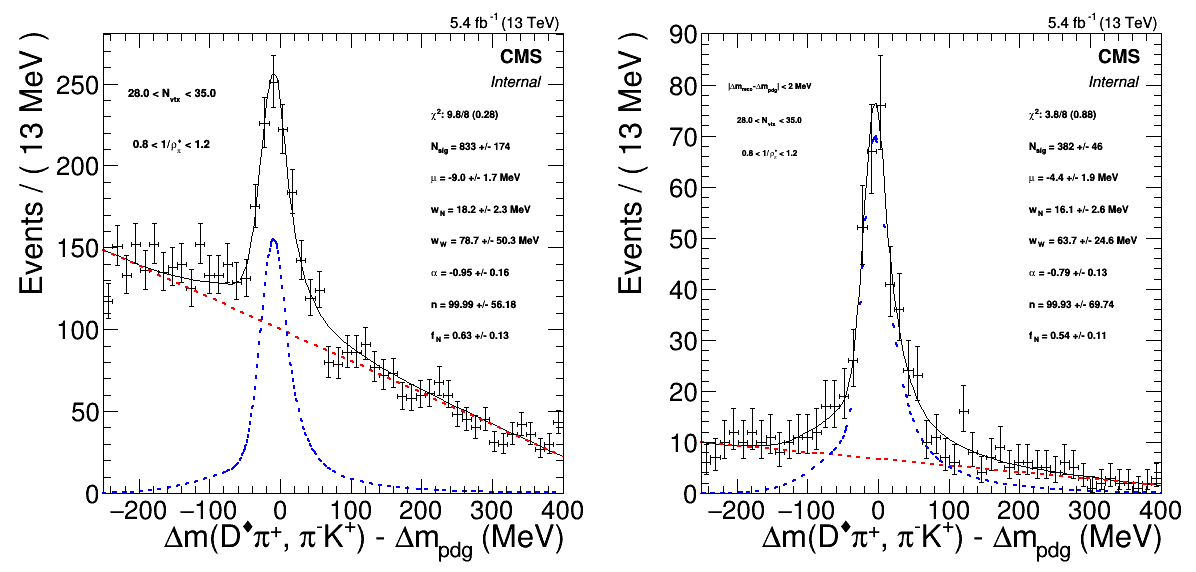

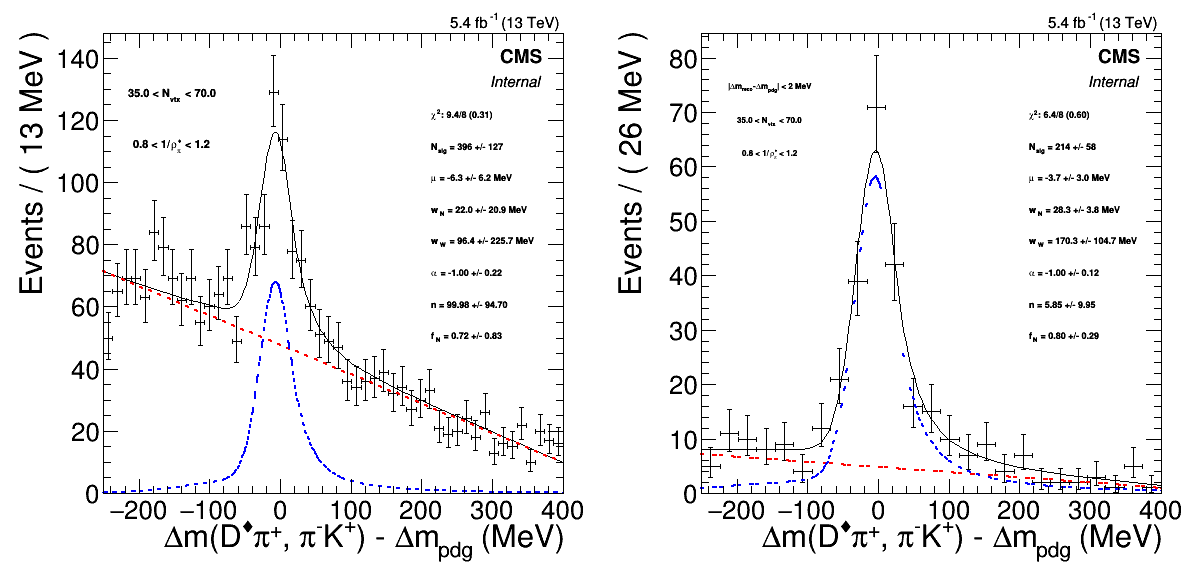

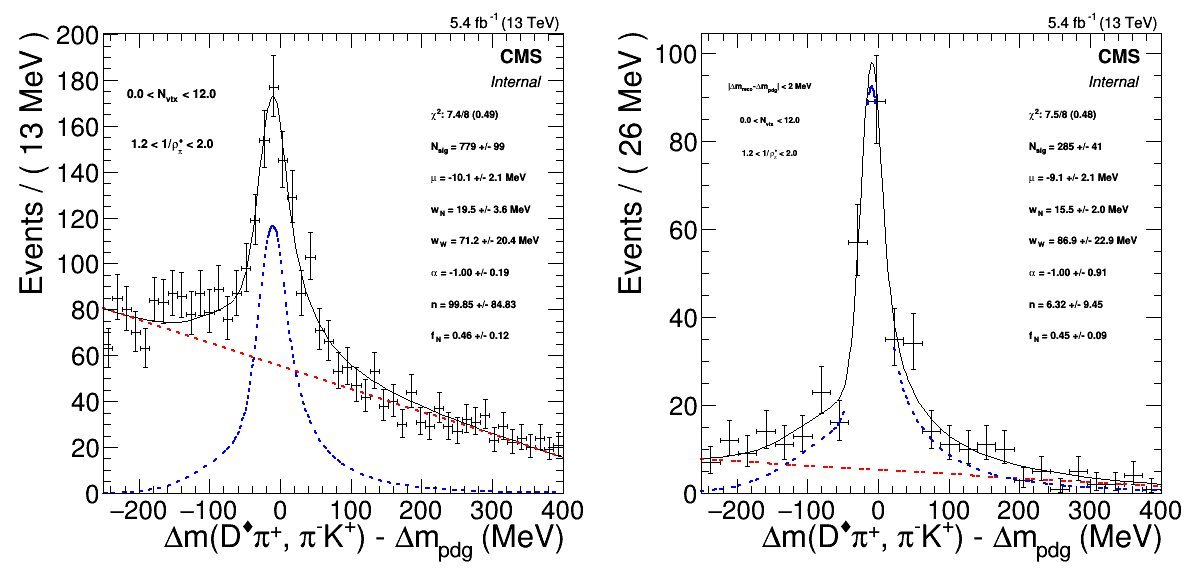

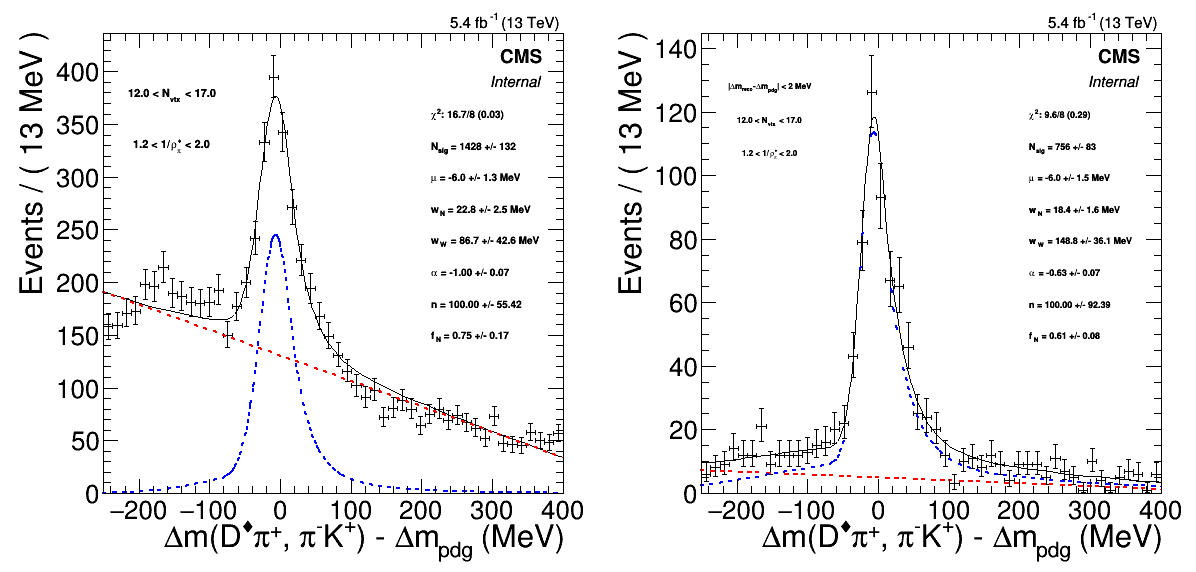

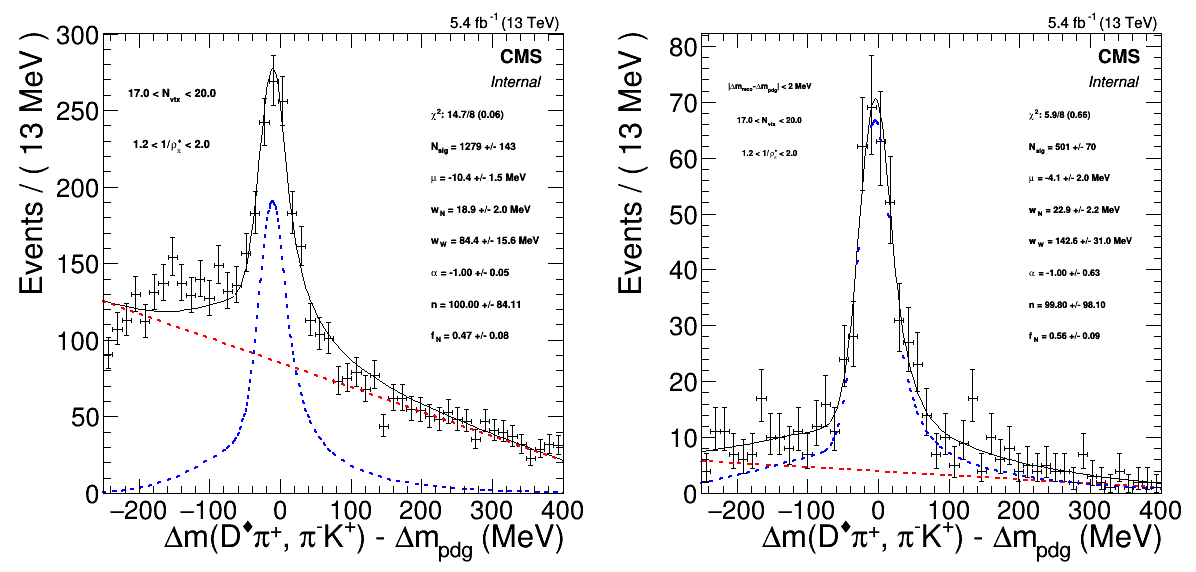

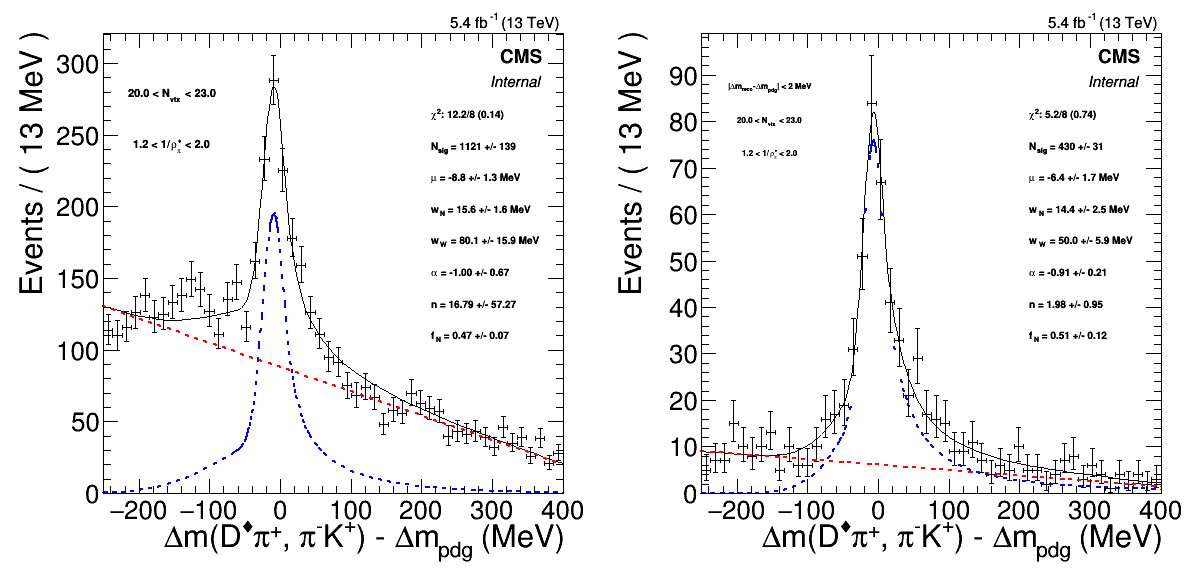

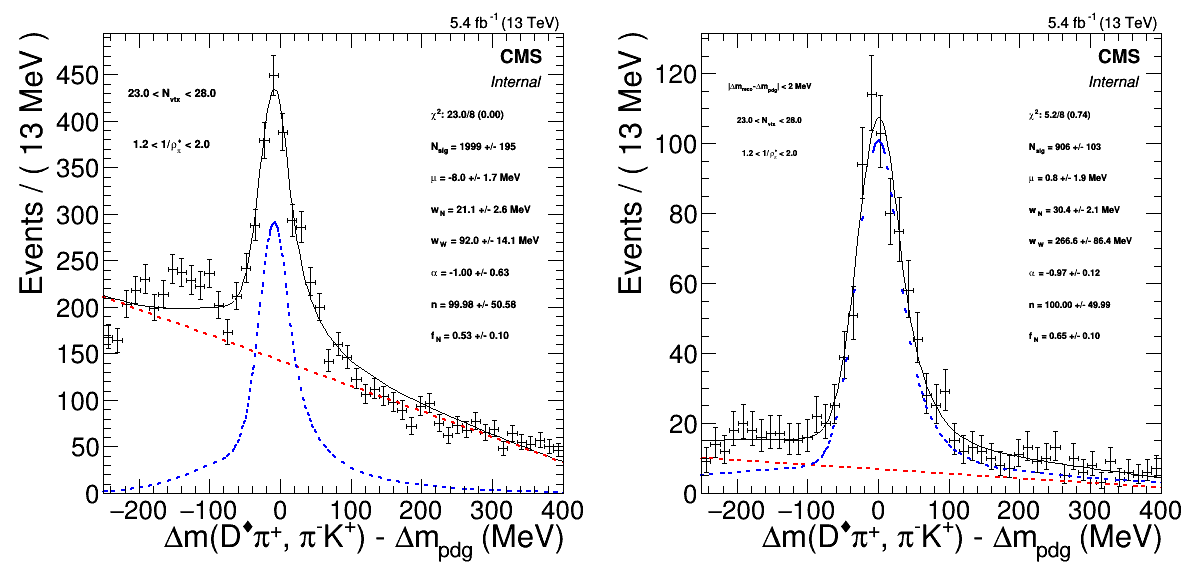

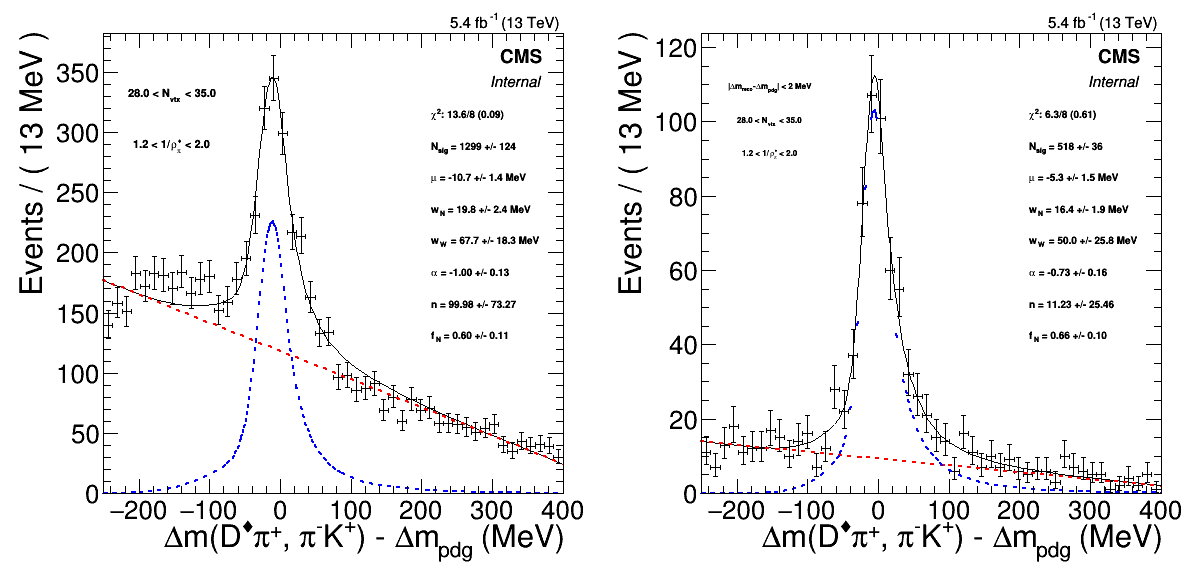

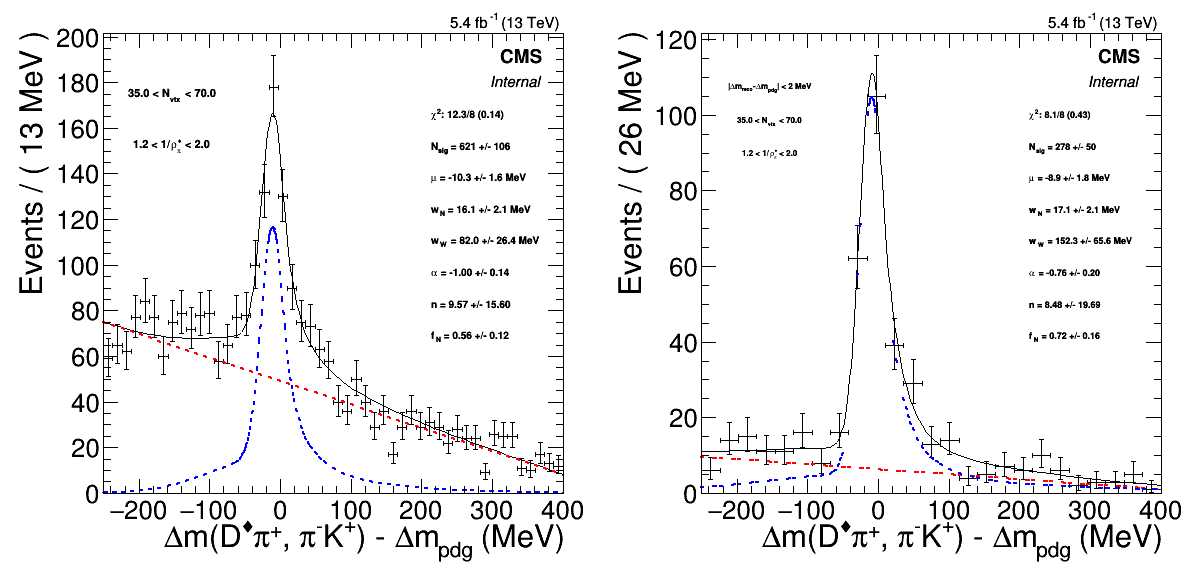

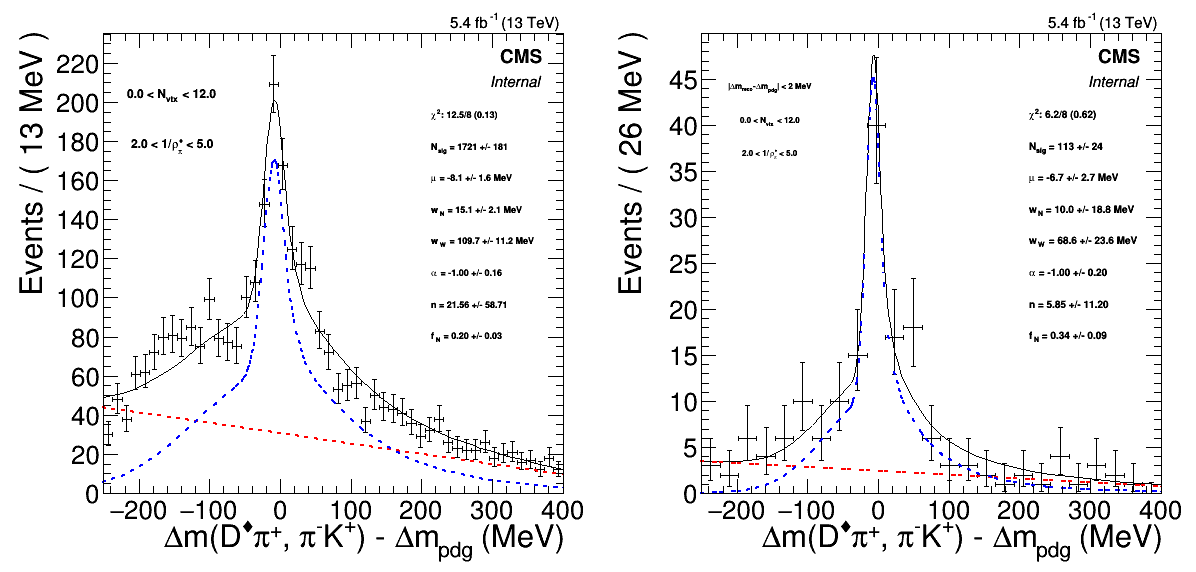

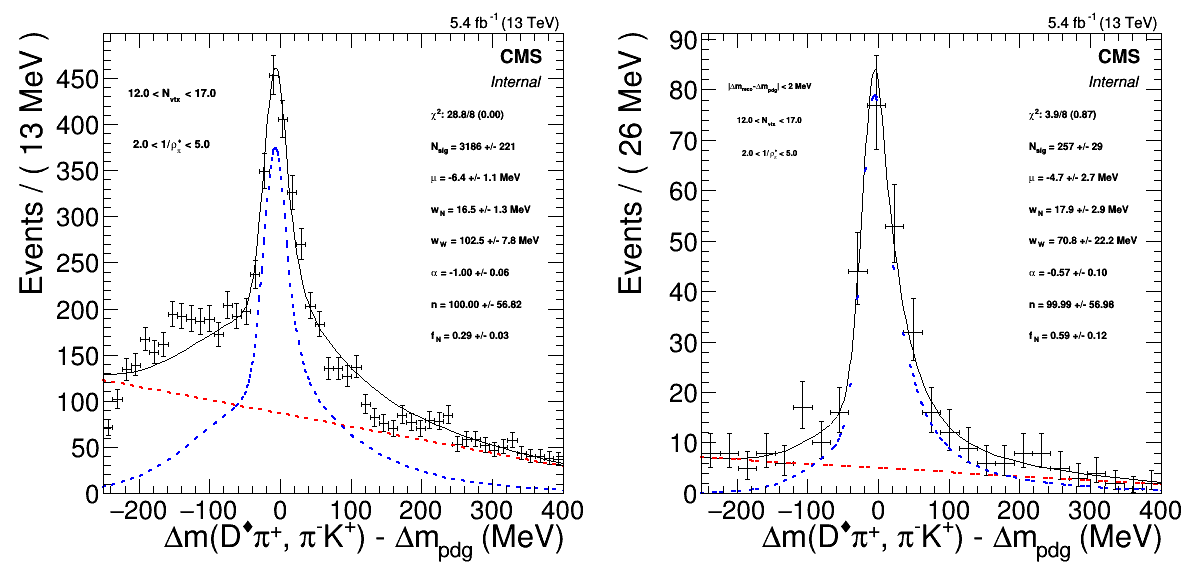

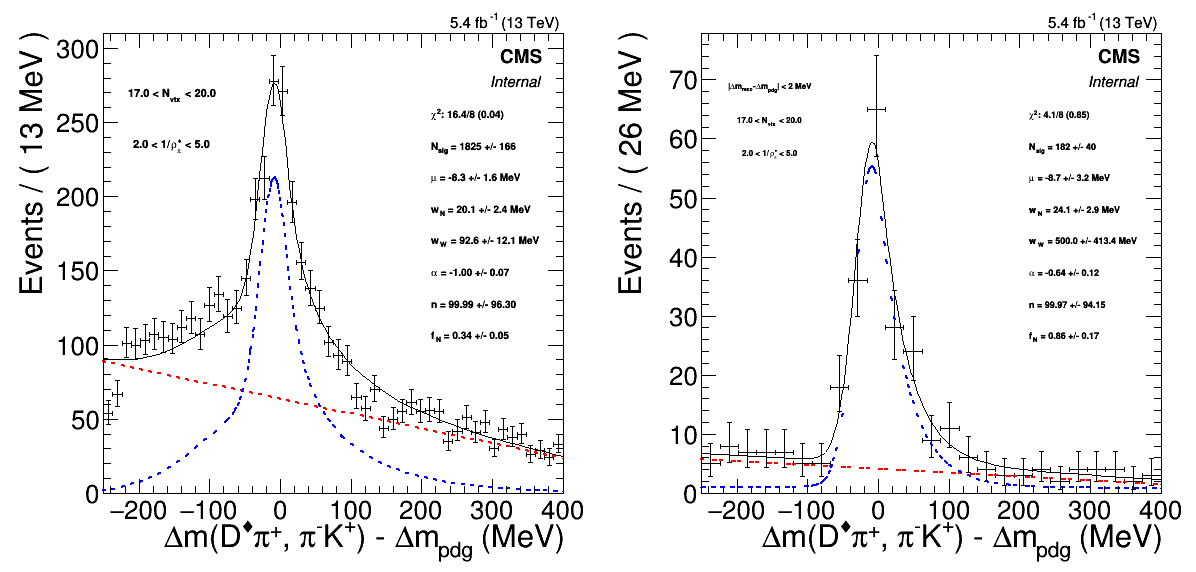

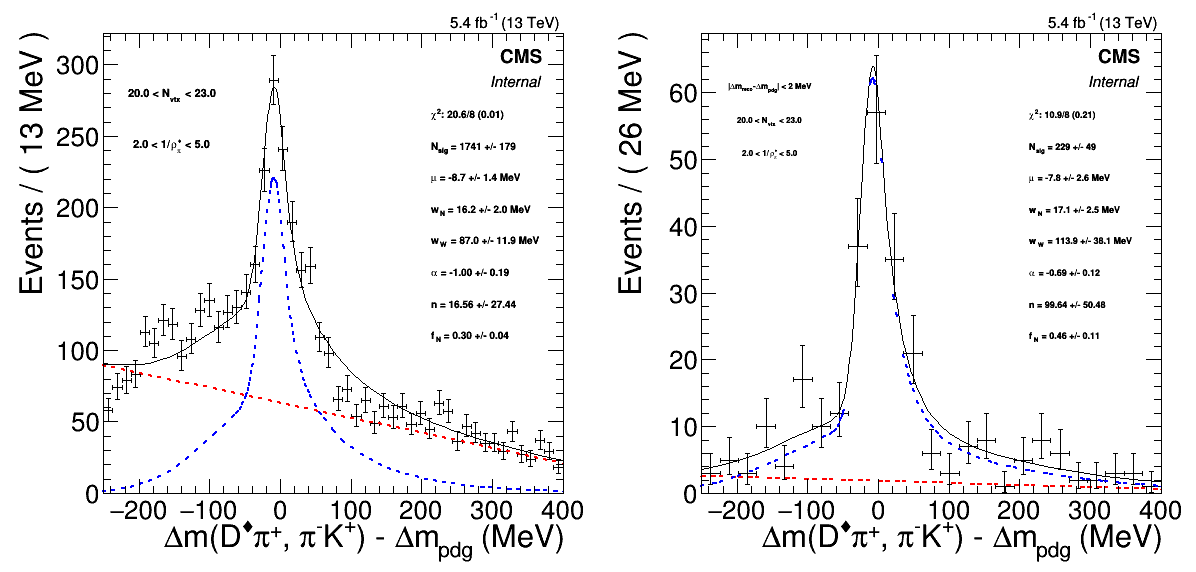

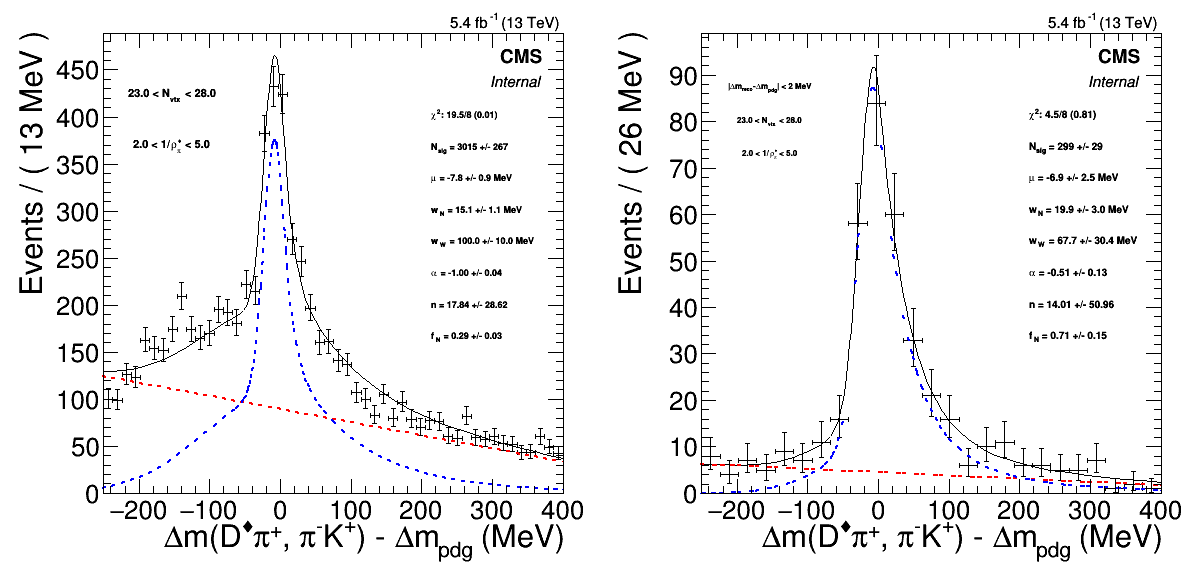

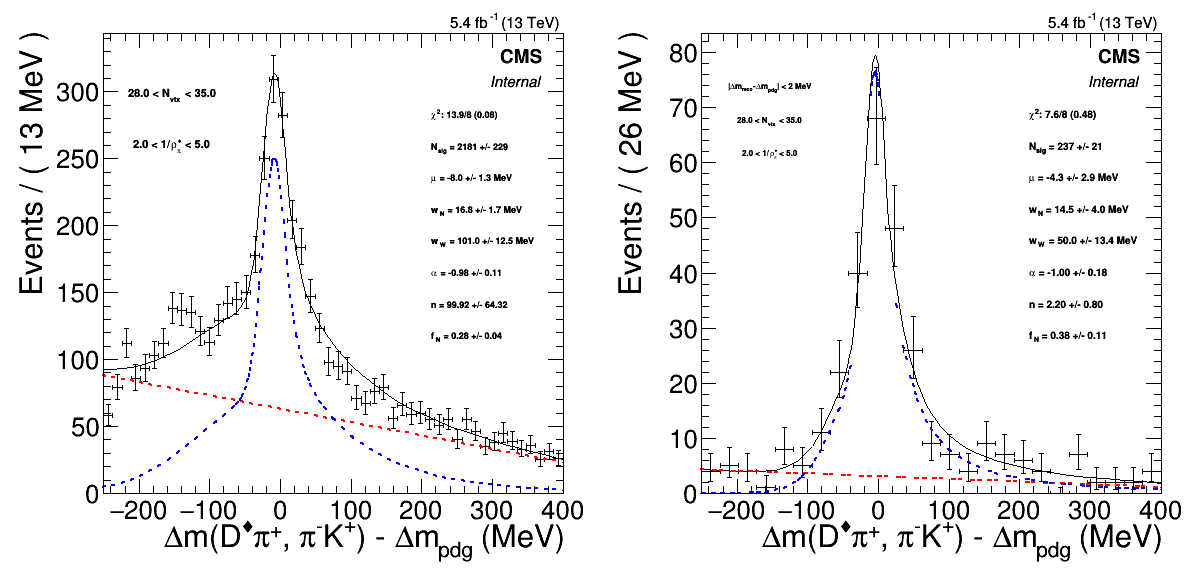

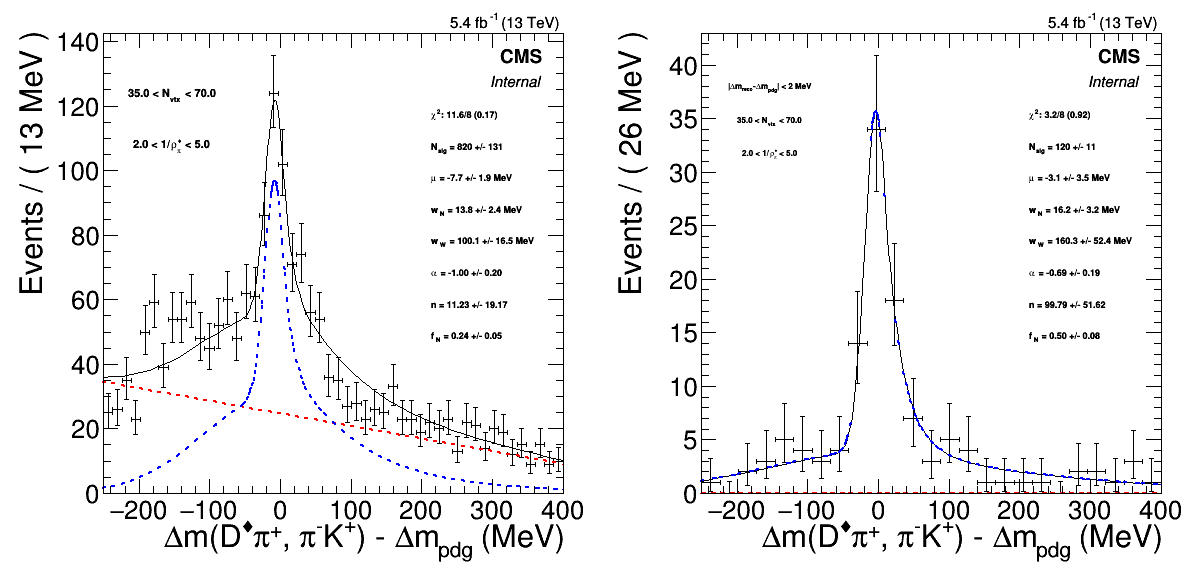

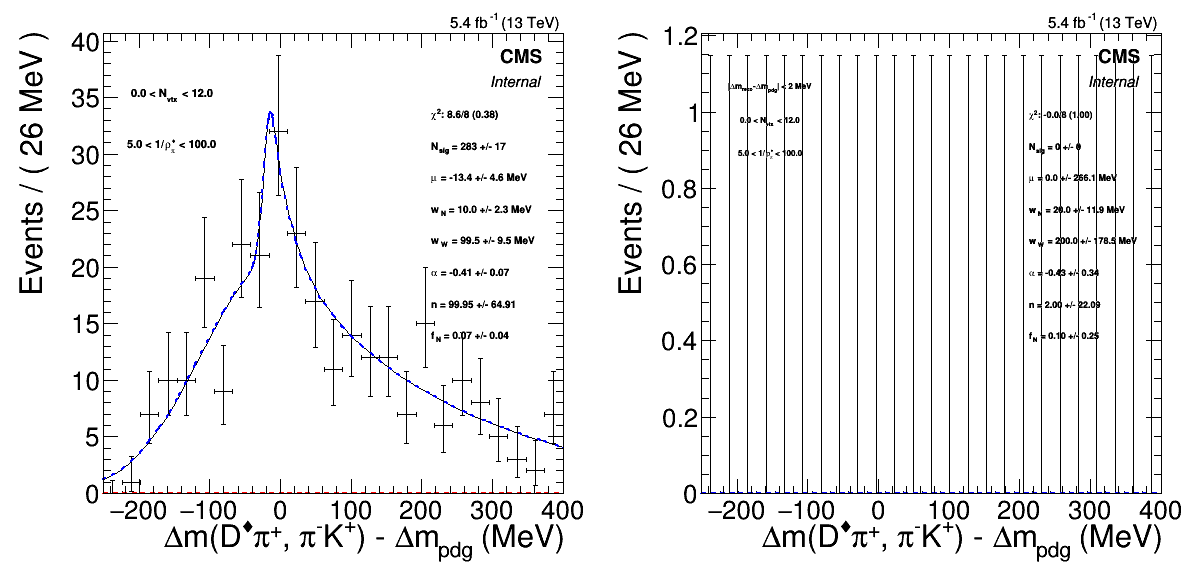

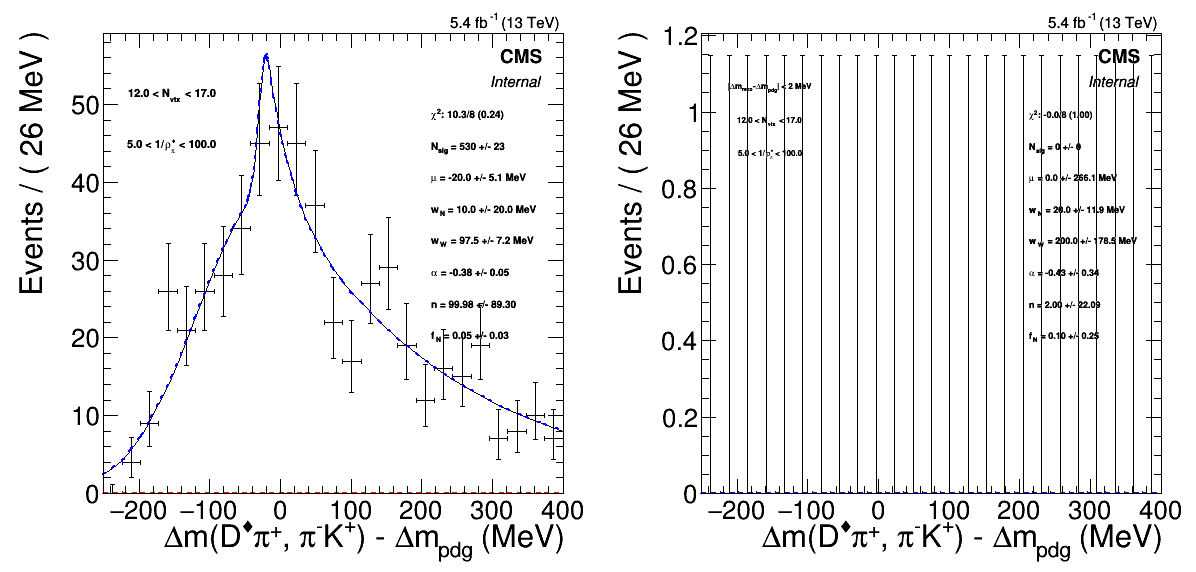

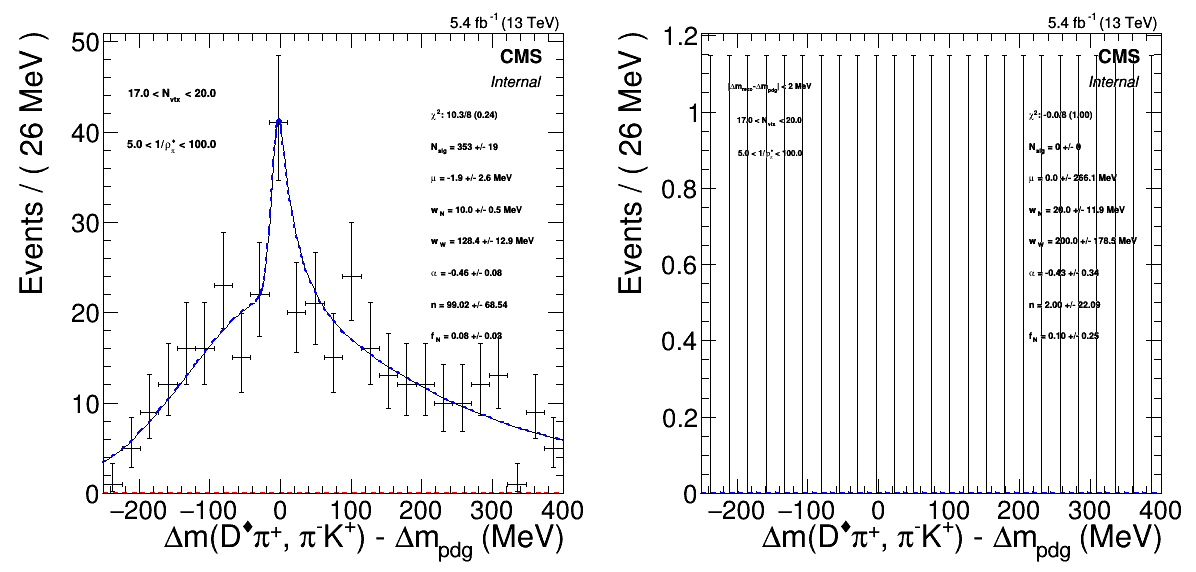

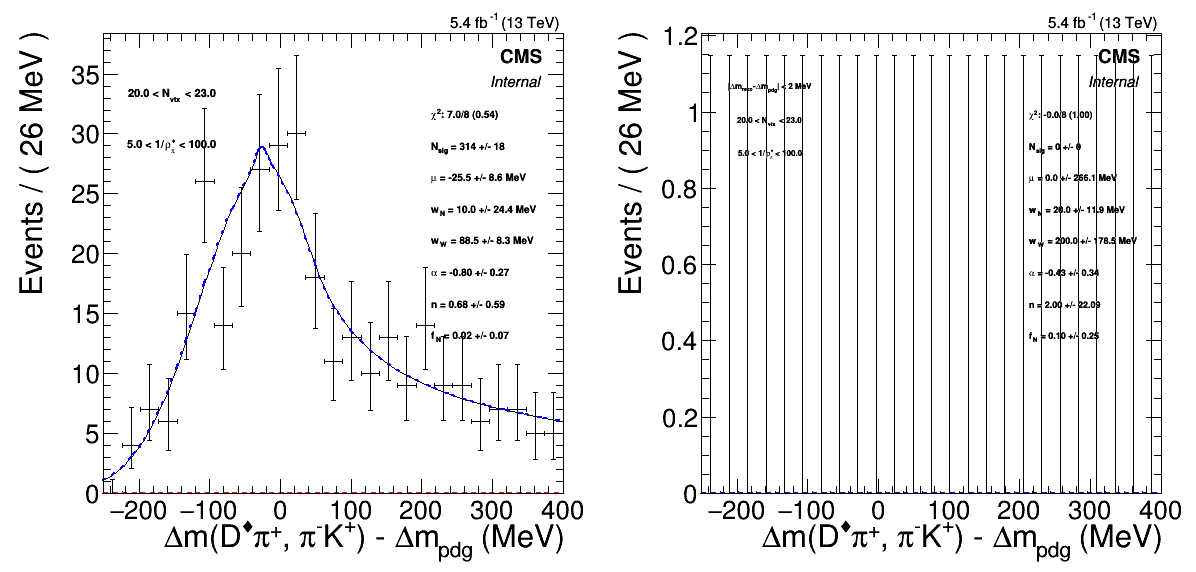

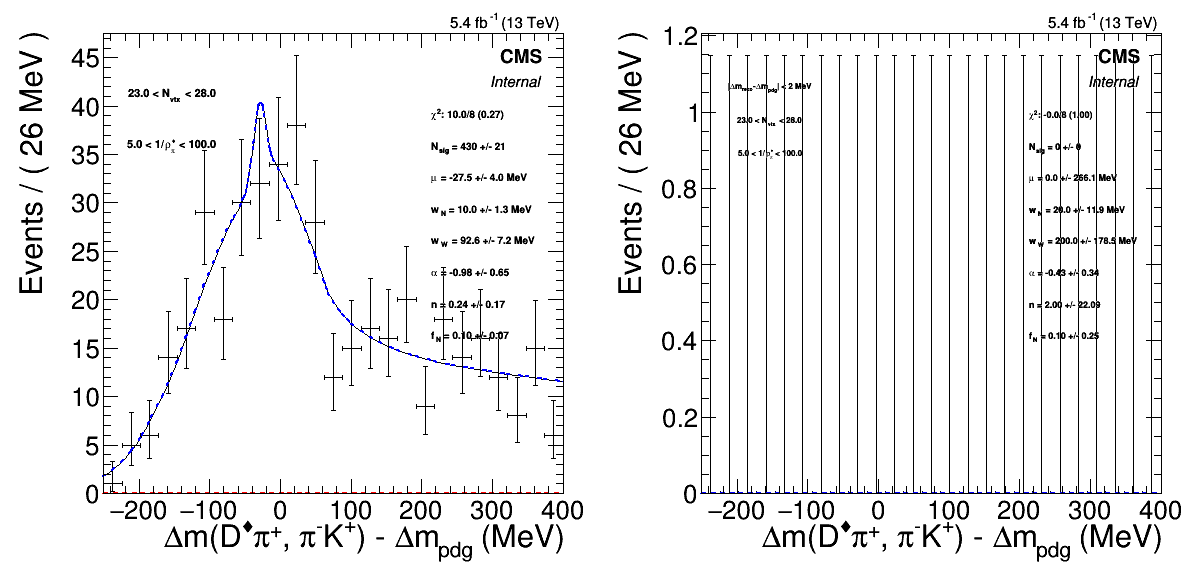

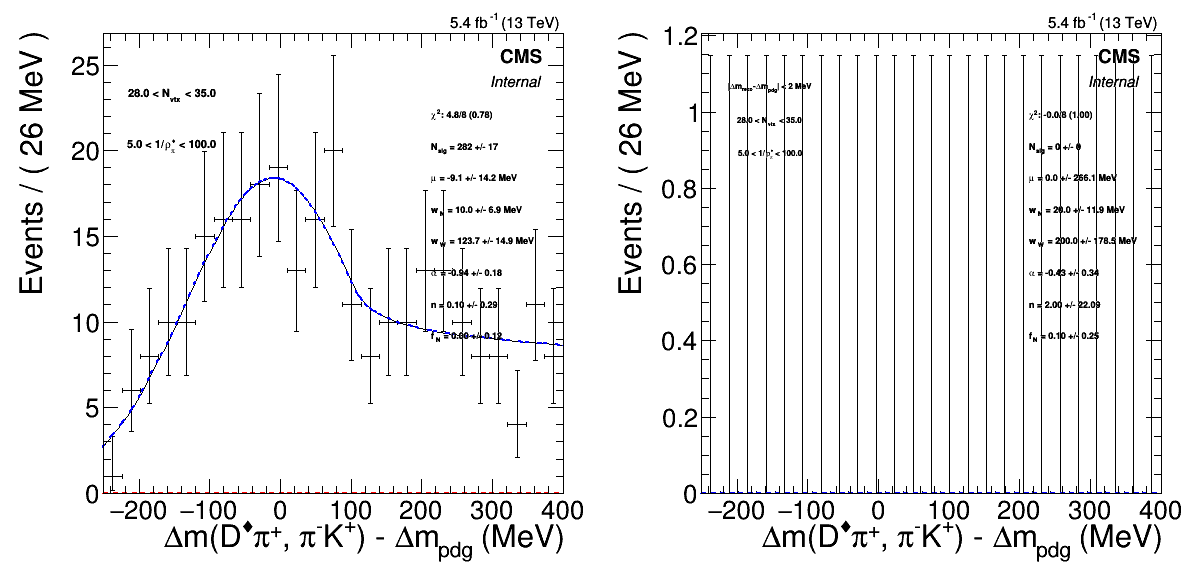

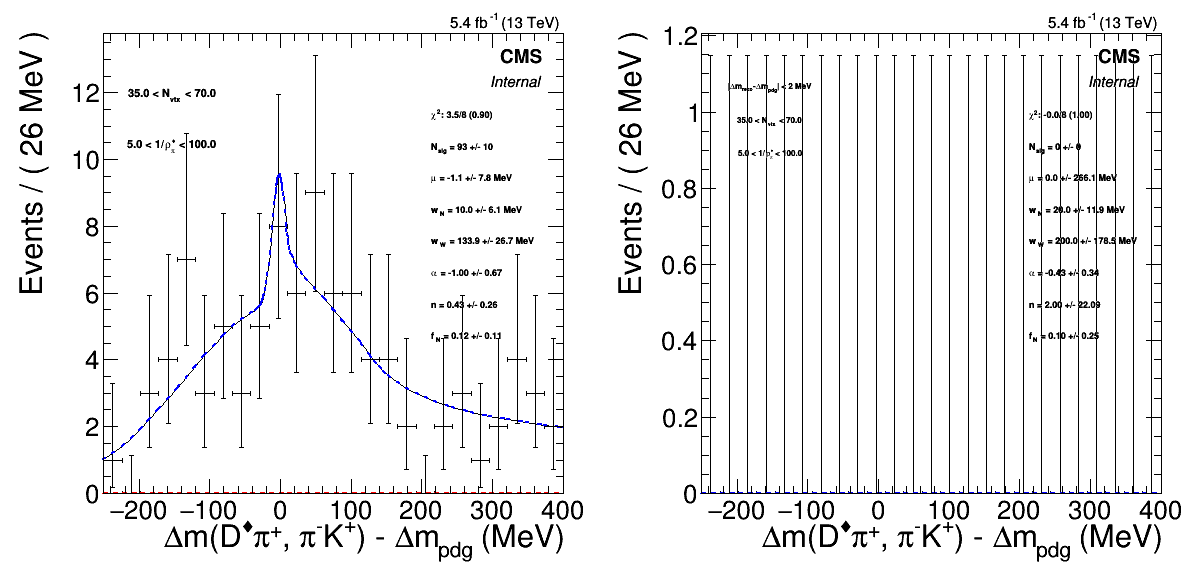

In [21]:
for c, idx, nSigTot, pValTot, nSigPass, pValPass in output:
    i1 = idx['expPis_k']+1
    i2 = idx['N_vtx']+1
    h2['Ntot'].SetBinContent(i1, i2, int(np.ceil(nSigTot[0])))
    h2['Ntot'].SetBinError(h2['Ntot'].GetBin(i1, i2), nSigTot[1])
    h2['Chi2tot'].SetBinContent(i1, i2, pValTot[0])
    h2['Chi2tot'].SetBinError(h2['Chi2tot'].GetBin(i1, i2), pValTot[1])
    h2['Npass'].SetBinContent(i1, i2, int(nSigPass[0]))
    h2['Npass'].SetBinError(h2['Npass'].GetBin(i1, i2), nSigPass[1])
    h2['Chi2pass'].SetBinContent(i1, i2, pValPass[0])
    h2['Chi2pass'].SetBinError(h2['Chi2pass'].GetBin(i1, i2), pValPass[1])
    c.Draw()
    if np.isnan(nSigTot[1]) or np.isnan(nSigPass[1]):
        print nSigTot[1], nSigPass[1]
        break

In [22]:
for i1 in range(1, h2['Npass'].GetNbinsX()+1):
        for i2 in range(1, h2['Npass'].GetNbinsY()+1):
            idx = h2['Npass'].GetBin(i1, i2)
            if h2['Npass'].GetBinContent(idx) > h2['Ntot'].GetBinContent(idx):
                print i1, i2, ': pass more than tot'
                print h2['Npass'].GetBinContent(idx), h2['Ntot'].GetBinContent(idx)
                h2['Npass'].SetBinContent(idx, h2['Ntot'].GetBinContent(idx))

In [23]:
if not rt.TEfficiency.CheckConsistency(h2['Npass'], h2['Ntot']): raise
pEff = rt.TEfficiency(h2['Npass'], h2['Ntot'])
# pEff.SetStatisticOption(rt.TEfficiency.kFCP)
# pEff.SetStatisticOption(rt.TEfficiency.kFWilson)
pEff.SetStatisticOption(rt.TEfficiency.kBJeffrey)
pEff.SetNameTitle('eff', 'Tracking efficience')

tf = rt.TFile('../data/calibration/trackingEfficiency/eff{}.root'.format(dataset), 'RECREATE')
pEff.Write()
for h in h2.values():
    h.Write()
tf.Close()

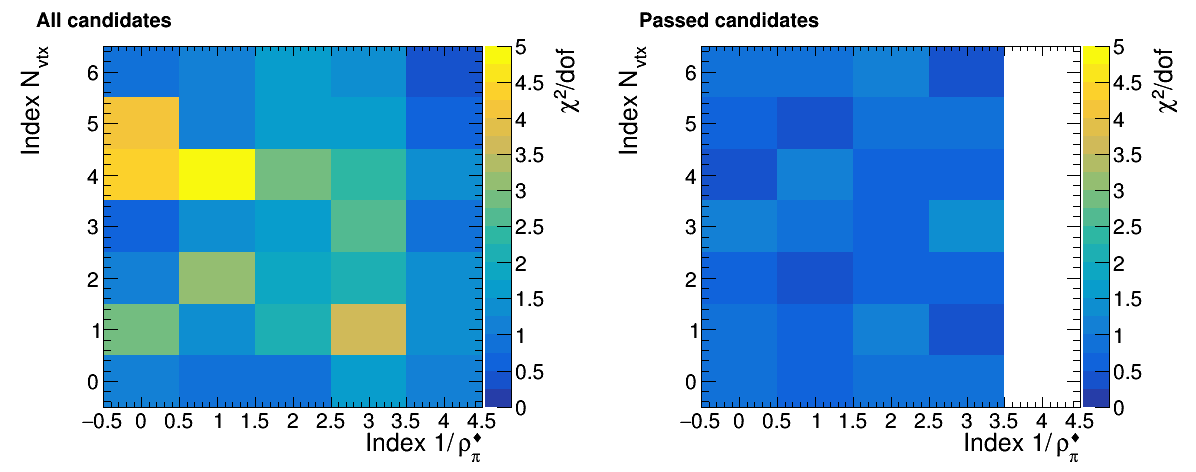

In [24]:
rt.gStyle.SetOptTitle(1)
rt.gStyle.SetTitleFillColor(0)
rt.gStyle.SetTitleBorderSize(0)
N_dof = h2['Chi2tot'].GetBinError(h2['Chi2tot'].GetBin(1,1,1))

h2_chi2tot = rt.TH2D('h2Chi2tot', 'All candidates', 
                     len(binning['expPis_k'])-1, -0.5, len(binning['expPis_k'])-1.5, 
                     len(binning['N_vtx'])-1, -0.5, len(binning['N_vtx'])-1.5
                    )
h2_chi2tot.GetXaxis().SetTitle('Index ' + varDic['expPis_k'])
h2_chi2tot.GetYaxis().SetTitle('Index ' + varDic['N_vtx'])
h2_chi2tot.GetZaxis().SetTitle('#chi^{2}/dof')
# h2_chi2tot.GetXaxis().SetNdivisions(1+len(binning['expPis_k']), 0, 0, False)
# h2_chi2tot.GetYaxis().SetNdivisions(1+len(binning['N_vtx']), 0, 0, False)
    

h2_chi2pass = rt.TH2D('h2Chi2pass', 'Passed candidates', 
                     len(binning['expPis_k'])-1, -0.5, len(binning['expPis_k'])-1.5, 
                     len(binning['N_vtx'])-1, -0.5, len(binning['N_vtx'])-1.5
                    )
h2_chi2pass.GetXaxis().SetTitle('Index ' + varDic['expPis_k'])
h2_chi2pass.GetYaxis().SetTitle('Index ' + varDic['N_vtx'])
h2_chi2pass.GetZaxis().SetTitle('#chi^{2}/dof')
    
for ix, iy in itertools.product(range(1, h2['Chi2tot'].GetNbinsX()+1), range(1, h2['Chi2tot'].GetNbinsY()+1)):
    idx = h2['Chi2tot'].GetBin(ix, iy)
    h2_chi2tot.SetBinContent(ix, iy, h2['Chi2tot'].GetBinContent(idx)/N_dof)
    h2_chi2pass.SetBinContent(ix, iy, h2['Chi2pass'].GetBinContent(idx)/N_dof)

c = rt.TCanvas('c_chi2', 'c_chi2', 50, 50, 1200, 500)
c.SetTickx(0)
c.SetTicky(0)
c.Divide(2)

p = c.cd(1)
h2_chi2tot.Draw('colz')
h2_chi2tot.GetZaxis().SetRangeUser(0, 5)
p.SetTopMargin(0.09)
p.SetRightMargin(0.18)

p = c.cd(2)
h2_chi2pass.Draw('colz')
h2_chi2pass.GetZaxis().SetRangeUser(0, 5)
p.SetTopMargin(0.09)
p.SetRightMargin(0.18)

c.Draw()
imgLoc = '../data/calibration/trackingEfficiency/figFit'+dataset
c.SaveAs(imgLoc + '/' + 'chi2_fit.png')

6.0: 0.38 -0.11/+0.11
14.5: 0.07 -0.01/+0.01
18.5: 0.45 -0.16/+0.16
21.5: 0.56 -0.11/+0.11
25.5: 0.10 -0.01/+0.01
31.5: 0.10 -0.07/+0.07
52.5: 0.82 -0.11/+0.11



6.0: 0.58 -0.07/+0.07
14.5: 0.50 -0.06/+0.06
18.5: 0.08 -0.01/+0.01
21.5: 0.46 -0.05/+0.05
25.5: 0.08 -0.00/+0.00
31.5: 0.46 -0.10/+0.10
52.5: 0.53 -0.15/+0.15



6.0: 0.37 -0.06/+0.06
14.5: 0.53 -0.05/+0.05
18.5: 0.39 -0.05/+0.05
21.5: 0.38 -0.06/+0.06
25.5: 0.45 -0.05/+0.05
31.5: 0.40 -0.05/+0.05
52.5: 0.45 -0.08/+0.08



6.0: 0.07 -0.03/+0.03
14.5: 0.08 -0.02/+0.02
18.5: 0.10 -0.03/+0.03
21.5: 0.13 -0.03/+0.03
25.5: 0.10 -0.03/+0.03
31.5: 0.11 -0.03/+0.03
52.5: 0.15 -0.06/+0.06



6.0: 0.00 -0.00/+0.00
14.5: 0.00 -0.00/+0.00
18.5: 0.00 -0.00/+0.00
21.5: 0.00 -0.00/+0.00
25.5: 0.00 -0.00/+0.00
31.5: 0.00 -0.00/+0.00
52.5: 0.01 -0.00/+0.01





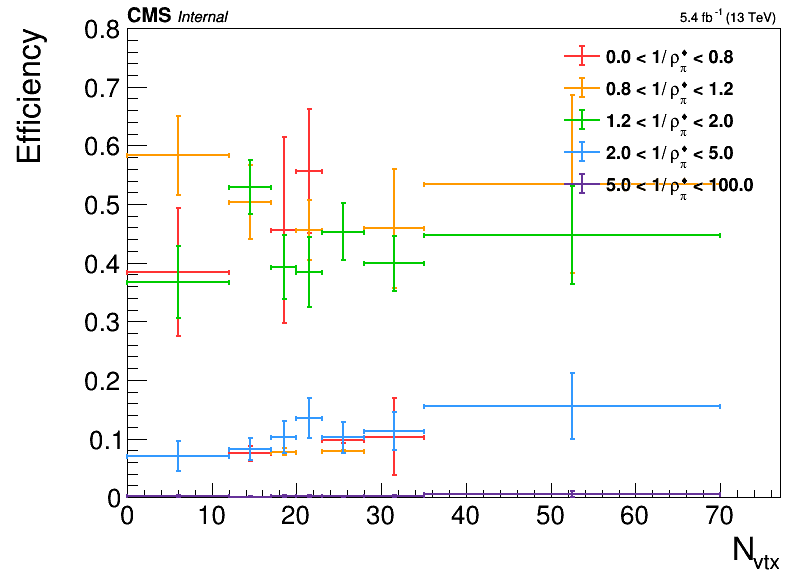

In [25]:
outCanvases = []
tdrstyle.setTDRStyle()
BRY_colors = [rt.kRed-4,
              rt.kOrange-3,
              rt.kGreen+1, 
              rt.kAzure+1,
              rt.kViolet-7]
hRef = h2['Chi2tot']
    
leg = rt.TLegend(0.7, 0.65, 0.95, 0.93)
leg.SetLineWidth(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
gr2draw = []

for ix in range(1, hRef.GetNbinsX()+1):
    gr = rt.TGraphAsymmErrors()
    for iy in range(1, hRef.GetNbinsY()+1):
        idx = pEff.GetGlobalBin(ix, iy)
        xgr = binning['N_vtx'][iy-1] + 0.5*(binning['N_vtx'][iy] - binning['N_vtx'][iy-1])
        gr.SetPoint(iy-1, xgr, pEff.GetEfficiency(idx))
        gr.SetPointError(iy-1, xgr-binning['N_vtx'][iy-1], binning['N_vtx'][iy]-xgr, 
                         pEff.GetEfficiencyErrorLow(idx), pEff.GetEfficiencyErrorUp(idx)
                        )
        print '{:.1f}: {:.2f} -{:.2f}/+{:.2f}'.format(xgr, pEff.GetEfficiency(idx), pEff.GetEfficiencyErrorLow(idx), pEff.GetEfficiencyErrorUp(idx))
        if np.isnan(pEff.GetEfficiencyErrorLow(idx)) or np.isnan(pEff.GetEfficiencyErrorUp(idx)):
            print '\t {}/{}'.format(h2['Npass'].GetBinContent(idx), h2['Ntot'].GetBinContent(idx))
            e = pEff.GetEfficiency(idx)
            de = np.sqrt(e*(1-e)/h2['Ntot'].GetBinContent(idx))
            gr.SetPointError(iy-1, xgr-binning['N_vtx'][iy-1], binning['N_vtx'][iy]-xgr, de, de)
            
    gr.SetLineColor(BRY_colors[ix-1])
    gr.SetLineWidth(2)
    gr.SetMarkerColor(BRY_colors[ix-1])
    leg.AddEntry(gr, '{:.1f} < {} < {:.1f}'.format(binning['expPis_k'][ix-1], varDic['expPis_k'], binning['expPis_k'][ix]), 'lep')
    gr2draw.append(gr)
    print '\n\n'

M = 0.8
m = 0
gr2draw[0].GetYaxis().SetRangeUser(m ,M)
c = drawOnCMSCanvas(CMS_lumi, gr2draw, ['AP'] + (len(gr2draw)-1)*['P'], tag='_eff')    
gr2draw[0].GetYaxis().SetTitle('Efficiency')
gr2draw[0].GetXaxis().SetTitle(varDic['N_vtx'])
leg.Draw()
gr2draw[0].GetXaxis().SetTitleOffset(1.)
    
l = rt.TLine()
l.SetLineWidth(1)
l.SetLineColor(rt.kGray)
l.SetLineStyle(7)
l.DrawLine(binning['N_vtx'][0], 1, binning['N_vtx'][-1], 1)

imgLoc = '../data/calibration/trackingEfficiency/figEff/'
if not os.path.isdir(imgLoc): os.makedirs(imgLoc)
c.SaveAs(imgLoc + 'eff' + dataset + '.png')
outCanvases.append([c, gr2draw, leg])
# c.SetLogy()